In [1]:
import os
import logging
import pickle

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import mlflow
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error

import optuna
from optuna.integration import LightGBMPruningCallback
import lightgbm as lgbm

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
logging.basicConfig(format='[%(asctime)s] (%(levelname)s): %(message)s', level=logging.INFO)
params = {
    'N_THREADS': 4,
    'RANDOM_STATE': 42,
    'TEST_SIZE': 0.2,
    'TIMEOUT': 60 * 60 * 5,  # in seconds
    'TARGET_NAME': 'accuracy',
    'GENERAL_PARAMS': {
        # available 'linear_l2', 'lgb', 'lgb_tuned', 'cb', 'cb_tuned'
        'use_algos': [['linear_l2', 'lgb', 'lgb_tuned'], ['lgb_tuned']]
    },
    'plot_feature_importances': True,
    'metric': 'mae',
    'loss': 'mae'
}

tqdm.pandas()
np.random.seed(params['RANDOM_STATE'])

[2022-05-21 02:57:03,177] (INFO): Data splitted. Parts sizes: train_data = (1286282, 275), test_data = (321571, 275)


<AxesSubplot:xlabel='accuracy', ylabel='Count'>

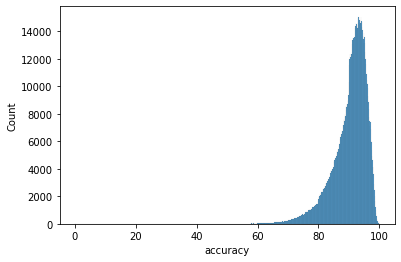

In [3]:
cols_to_drop = ['uploaded', 'leaderboardId', 'playerId']
data = pd.read_pickle('../data/processed/train_data.pkl').drop(columns=cols_to_drop).astype(float)
train_data, test_data = train_test_split(data, test_size=params['TEST_SIZE'], random_state=params['RANDOM_STATE'])
logging.info(f'Data splitted. Parts sizes: train_data = {train_data.shape}, test_data = {test_data.shape}')

In [4]:
def objective(trial, X, y):
    param_grid = {
        "n_estimators": trial.suggest_categorical("n_estimators", [5000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.9, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.9, step=0.1
        ),
    }

    cv = KFold(n_splits=5, shuffle=True, random_state=params['RANDOM_STATE'])

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = lgbm.LGBMRegressor(objective="regression", 
                                   verbose=1,
                                   metric=['l1','l2'],
                                   **param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric=['l1','l2'],
            early_stopping_rounds=100,
            callbacks=[
                LightGBMPruningCallback(trial, "l1")
            ],
        )
        preds = model.predict(X_test)
        cv_scores[idx] = mean_absolute_error(y_test, preds)
    return np.mean(cv_scores)

In [ ]:
train_data = train_data.reset_index().drop(columns='index')
study = optuna.create_study(direction="minimize", study_name="LGBM Regressor")
func = lambda trial: objective(trial, train_data.drop(columns=[params['TARGET_NAME']]), train_data[params['TARGET_NAME']])
study.optimize(func, n_trials=20)

In [8]:
print(f"\tBest value (mae): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (mae): 2.10725
	Best params:
		n_estimators: 5000
		learning_rate: 0.04534004109975924
		num_leaves: 1240
		max_depth: 9
		min_data_in_leaf: 800
		lambda_l1: 70
		lambda_l2: 70
		min_gain_to_split: 12.675416978931597
		bagging_fraction: 0.7
		bagging_freq: 1
		feature_fraction: 0.5


In [ ]:
study.best_params.items()

In [13]:
logging.info('Starting fit')

hyper_params = study.best_params
hyper_params['n_estimators'] = hyper_params['n_estimators'] * 2

gbm = lgbm.LGBMRegressor(task='train',
                         boosting_type='gbdt', 
                         objective='regression',
                         metric=['l1','l2'],
                         verbose=0,
                         **hyper_params)
gbm.fit(train_data.drop(columns=[params['TARGET_NAME']]), train_data[params['TARGET_NAME']],
        eval_set=[(test_data.drop(columns=[params['TARGET_NAME']]), test_data[params['TARGET_NAME']])],
        eval_metric=params['metric'],
        early_stopping_rounds=1000)
        
y_pred = gbm.predict(test_data.drop(columns=[params['TARGET_NAME']]), num_iteration=gbm.best_iteration_)
print('The mae of prediction is:', mean_absolute_error(y_pred, test_data[params['TARGET_NAME']]))

[2022-05-21 14:14:19,518] (INFO): Starting fit


[1]	valid_0's l1: 4.18487	valid_0's l2: 31.7198
Training until validation scores don't improve for 1000 rounds
[2]	valid_0's l1: 4.12786	valid_0's l2: 30.9627
[3]	valid_0's l1: 4.04225	valid_0's l2: 29.829
[4]	valid_0's l1: 3.95744	valid_0's l2: 28.7315
[5]	valid_0's l1: 3.90282	valid_0's l2: 28.0461
[6]	valid_0's l1: 3.82787	valid_0's l2: 27.1134
[7]	valid_0's l1: 3.76248	valid_0's l2: 26.3128
[8]	valid_0's l1: 3.70187	valid_0's l2: 25.5911
[9]	valid_0's l1: 3.63631	valid_0's l2: 24.8101
[10]	valid_0's l1: 3.59677	valid_0's l2: 24.3627
[11]	valid_0's l1: 3.55554	valid_0's l2: 23.8976
[12]	valid_0's l1: 3.49859	valid_0's l2: 23.2502
[13]	valid_0's l1: 3.46571	valid_0's l2: 22.8926
[14]	valid_0's l1: 3.43147	valid_0's l2: 22.5266
[15]	valid_0's l1: 3.40342	valid_0's l2: 22.2321
[16]	valid_0's l1: 3.35288	valid_0's l2: 21.6824
[17]	valid_0's l1: 3.32488	valid_0's l2: 21.398
[18]	valid_0's l1: 3.28557	valid_0's l2: 20.9847
[19]	valid_0's l1: 3.24008	valid_0's l2: 20.5056
[20]	valid_0's l1

[167]	valid_0's l1: 2.27245	valid_0's l2: 12.0722
[168]	valid_0's l1: 2.27179	valid_0's l2: 12.0656
[169]	valid_0's l1: 2.27127	valid_0's l2: 12.0614
[170]	valid_0's l1: 2.27045	valid_0's l2: 12.0549
[171]	valid_0's l1: 2.26982	valid_0's l2: 12.0483
[172]	valid_0's l1: 2.26913	valid_0's l2: 12.0424
[173]	valid_0's l1: 2.26858	valid_0's l2: 12.0377
[174]	valid_0's l1: 2.2678	valid_0's l2: 12.0315
[175]	valid_0's l1: 2.26699	valid_0's l2: 12.0232
[176]	valid_0's l1: 2.26606	valid_0's l2: 12.0141
[177]	valid_0's l1: 2.26513	valid_0's l2: 12.0052
[178]	valid_0's l1: 2.26486	valid_0's l2: 12.0029
[179]	valid_0's l1: 2.26422	valid_0's l2: 11.9975
[180]	valid_0's l1: 2.26386	valid_0's l2: 11.9942
[181]	valid_0's l1: 2.2632	valid_0's l2: 11.9875
[182]	valid_0's l1: 2.26253	valid_0's l2: 11.981
[183]	valid_0's l1: 2.26165	valid_0's l2: 11.973
[184]	valid_0's l1: 2.26081	valid_0's l2: 11.9654
[185]	valid_0's l1: 2.26042	valid_0's l2: 11.9618
[186]	valid_0's l1: 2.26023	valid_0's l2: 11.9602
[187

[332]	valid_0's l1: 2.20914	valid_0's l2: 11.4716
[333]	valid_0's l1: 2.20885	valid_0's l2: 11.4685
[334]	valid_0's l1: 2.2087	valid_0's l2: 11.4672
[335]	valid_0's l1: 2.20854	valid_0's l2: 11.4658
[336]	valid_0's l1: 2.20841	valid_0's l2: 11.4645
[337]	valid_0's l1: 2.20798	valid_0's l2: 11.4604
[338]	valid_0's l1: 2.20741	valid_0's l2: 11.4545
[339]	valid_0's l1: 2.20724	valid_0's l2: 11.4529
[340]	valid_0's l1: 2.20694	valid_0's l2: 11.4501
[341]	valid_0's l1: 2.20683	valid_0's l2: 11.4493
[342]	valid_0's l1: 2.20667	valid_0's l2: 11.4475
[343]	valid_0's l1: 2.20643	valid_0's l2: 11.445
[344]	valid_0's l1: 2.20617	valid_0's l2: 11.4427
[345]	valid_0's l1: 2.20611	valid_0's l2: 11.4415
[346]	valid_0's l1: 2.20605	valid_0's l2: 11.4405
[347]	valid_0's l1: 2.20574	valid_0's l2: 11.438
[348]	valid_0's l1: 2.20551	valid_0's l2: 11.4355
[349]	valid_0's l1: 2.20526	valid_0's l2: 11.4333
[350]	valid_0's l1: 2.205	valid_0's l2: 11.4309
[351]	valid_0's l1: 2.20478	valid_0's l2: 11.4285
[352]

[497]	valid_0's l1: 2.17906	valid_0's l2: 11.1679
[498]	valid_0's l1: 2.17886	valid_0's l2: 11.1659
[499]	valid_0's l1: 2.17881	valid_0's l2: 11.1654
[500]	valid_0's l1: 2.17865	valid_0's l2: 11.164
[501]	valid_0's l1: 2.17854	valid_0's l2: 11.1624
[502]	valid_0's l1: 2.17842	valid_0's l2: 11.1615
[503]	valid_0's l1: 2.17826	valid_0's l2: 11.1601
[504]	valid_0's l1: 2.17808	valid_0's l2: 11.1584
[505]	valid_0's l1: 2.17803	valid_0's l2: 11.1574
[506]	valid_0's l1: 2.17796	valid_0's l2: 11.1564
[507]	valid_0's l1: 2.17785	valid_0's l2: 11.1553
[508]	valid_0's l1: 2.1777	valid_0's l2: 11.1537
[509]	valid_0's l1: 2.17761	valid_0's l2: 11.1531
[510]	valid_0's l1: 2.17744	valid_0's l2: 11.1514
[511]	valid_0's l1: 2.17732	valid_0's l2: 11.1505
[512]	valid_0's l1: 2.17728	valid_0's l2: 11.1503
[513]	valid_0's l1: 2.17717	valid_0's l2: 11.1487
[514]	valid_0's l1: 2.17708	valid_0's l2: 11.1474
[515]	valid_0's l1: 2.17701	valid_0's l2: 11.1467
[516]	valid_0's l1: 2.17688	valid_0's l2: 11.1451
[5

[662]	valid_0's l1: 2.16175	valid_0's l2: 10.9867
[663]	valid_0's l1: 2.16172	valid_0's l2: 10.9861
[664]	valid_0's l1: 2.16154	valid_0's l2: 10.9846
[665]	valid_0's l1: 2.16146	valid_0's l2: 10.9837
[666]	valid_0's l1: 2.16137	valid_0's l2: 10.9828
[667]	valid_0's l1: 2.16126	valid_0's l2: 10.9816
[668]	valid_0's l1: 2.16124	valid_0's l2: 10.9811
[669]	valid_0's l1: 2.16119	valid_0's l2: 10.9805
[670]	valid_0's l1: 2.16097	valid_0's l2: 10.9784
[671]	valid_0's l1: 2.16088	valid_0's l2: 10.9779
[672]	valid_0's l1: 2.16086	valid_0's l2: 10.9774
[673]	valid_0's l1: 2.16083	valid_0's l2: 10.9769
[674]	valid_0's l1: 2.16073	valid_0's l2: 10.9755
[675]	valid_0's l1: 2.16072	valid_0's l2: 10.9753
[676]	valid_0's l1: 2.16067	valid_0's l2: 10.9747
[677]	valid_0's l1: 2.16062	valid_0's l2: 10.974
[678]	valid_0's l1: 2.16058	valid_0's l2: 10.9734
[679]	valid_0's l1: 2.16048	valid_0's l2: 10.9721
[680]	valid_0's l1: 2.16033	valid_0's l2: 10.9705
[681]	valid_0's l1: 2.16026	valid_0's l2: 10.9698
[

[827]	valid_0's l1: 2.14858	valid_0's l2: 10.8479
[828]	valid_0's l1: 2.14856	valid_0's l2: 10.8476
[829]	valid_0's l1: 2.1485	valid_0's l2: 10.8469
[830]	valid_0's l1: 2.14846	valid_0's l2: 10.8465
[831]	valid_0's l1: 2.14846	valid_0's l2: 10.8462
[832]	valid_0's l1: 2.1484	valid_0's l2: 10.8457
[833]	valid_0's l1: 2.14836	valid_0's l2: 10.8453
[834]	valid_0's l1: 2.14832	valid_0's l2: 10.8449
[835]	valid_0's l1: 2.14826	valid_0's l2: 10.8444
[836]	valid_0's l1: 2.1481	valid_0's l2: 10.843
[837]	valid_0's l1: 2.14804	valid_0's l2: 10.8421
[838]	valid_0's l1: 2.14801	valid_0's l2: 10.8415
[839]	valid_0's l1: 2.14799	valid_0's l2: 10.8411
[840]	valid_0's l1: 2.14793	valid_0's l2: 10.8404
[841]	valid_0's l1: 2.14787	valid_0's l2: 10.84
[842]	valid_0's l1: 2.14779	valid_0's l2: 10.8393
[843]	valid_0's l1: 2.14773	valid_0's l2: 10.8388
[844]	valid_0's l1: 2.14762	valid_0's l2: 10.838
[845]	valid_0's l1: 2.14759	valid_0's l2: 10.8376
[846]	valid_0's l1: 2.14758	valid_0's l2: 10.8373
[847]	v

[992]	valid_0's l1: 2.139	valid_0's l2: 10.745
[993]	valid_0's l1: 2.13895	valid_0's l2: 10.7446
[994]	valid_0's l1: 2.13894	valid_0's l2: 10.7444
[995]	valid_0's l1: 2.1389	valid_0's l2: 10.7438
[996]	valid_0's l1: 2.13886	valid_0's l2: 10.7435
[997]	valid_0's l1: 2.13884	valid_0's l2: 10.743
[998]	valid_0's l1: 2.13881	valid_0's l2: 10.7428
[999]	valid_0's l1: 2.13874	valid_0's l2: 10.7421
[1000]	valid_0's l1: 2.13871	valid_0's l2: 10.7417
[1001]	valid_0's l1: 2.13867	valid_0's l2: 10.7415
[1002]	valid_0's l1: 2.13862	valid_0's l2: 10.7406
[1003]	valid_0's l1: 2.13861	valid_0's l2: 10.7403
[1004]	valid_0's l1: 2.13855	valid_0's l2: 10.7398
[1005]	valid_0's l1: 2.13844	valid_0's l2: 10.7388
[1006]	valid_0's l1: 2.13842	valid_0's l2: 10.7384
[1007]	valid_0's l1: 2.13836	valid_0's l2: 10.7377
[1008]	valid_0's l1: 2.1383	valid_0's l2: 10.7369
[1009]	valid_0's l1: 2.13824	valid_0's l2: 10.7363
[1010]	valid_0's l1: 2.13815	valid_0's l2: 10.7355
[1011]	valid_0's l1: 2.13806	valid_0's l2: 10

[1155]	valid_0's l1: 2.13114	valid_0's l2: 10.663
[1156]	valid_0's l1: 2.13104	valid_0's l2: 10.6622
[1157]	valid_0's l1: 2.13101	valid_0's l2: 10.662
[1158]	valid_0's l1: 2.13094	valid_0's l2: 10.6614
[1159]	valid_0's l1: 2.1309	valid_0's l2: 10.6611
[1160]	valid_0's l1: 2.13085	valid_0's l2: 10.6607
[1161]	valid_0's l1: 2.13082	valid_0's l2: 10.6605
[1162]	valid_0's l1: 2.1308	valid_0's l2: 10.6602
[1163]	valid_0's l1: 2.13077	valid_0's l2: 10.6595
[1164]	valid_0's l1: 2.13069	valid_0's l2: 10.6586
[1165]	valid_0's l1: 2.13062	valid_0's l2: 10.6579
[1166]	valid_0's l1: 2.13055	valid_0's l2: 10.6572
[1167]	valid_0's l1: 2.13052	valid_0's l2: 10.6568
[1168]	valid_0's l1: 2.13047	valid_0's l2: 10.6566
[1169]	valid_0's l1: 2.1304	valid_0's l2: 10.656
[1170]	valid_0's l1: 2.13033	valid_0's l2: 10.6554
[1171]	valid_0's l1: 2.1303	valid_0's l2: 10.6552
[1172]	valid_0's l1: 2.1303	valid_0's l2: 10.6551
[1173]	valid_0's l1: 2.1303	valid_0's l2: 10.6551
[1174]	valid_0's l1: 2.13026	valid_0's l

[1317]	valid_0's l1: 2.12443	valid_0's l2: 10.5911
[1318]	valid_0's l1: 2.12442	valid_0's l2: 10.5911
[1319]	valid_0's l1: 2.1244	valid_0's l2: 10.5907
[1320]	valid_0's l1: 2.1244	valid_0's l2: 10.5906
[1321]	valid_0's l1: 2.12439	valid_0's l2: 10.5904
[1322]	valid_0's l1: 2.12433	valid_0's l2: 10.5901
[1323]	valid_0's l1: 2.12432	valid_0's l2: 10.5896
[1324]	valid_0's l1: 2.12429	valid_0's l2: 10.5894
[1325]	valid_0's l1: 2.12423	valid_0's l2: 10.589
[1326]	valid_0's l1: 2.12418	valid_0's l2: 10.5887
[1327]	valid_0's l1: 2.12418	valid_0's l2: 10.5884
[1328]	valid_0's l1: 2.12414	valid_0's l2: 10.5881
[1329]	valid_0's l1: 2.12415	valid_0's l2: 10.5879
[1330]	valid_0's l1: 2.12411	valid_0's l2: 10.5876
[1331]	valid_0's l1: 2.1241	valid_0's l2: 10.5873
[1332]	valid_0's l1: 2.12407	valid_0's l2: 10.5868
[1333]	valid_0's l1: 2.12406	valid_0's l2: 10.5867
[1334]	valid_0's l1: 2.12397	valid_0's l2: 10.5857
[1335]	valid_0's l1: 2.12396	valid_0's l2: 10.5856
[1336]	valid_0's l1: 2.12385	valid_

[1480]	valid_0's l1: 2.11909	valid_0's l2: 10.5338
[1481]	valid_0's l1: 2.11905	valid_0's l2: 10.5336
[1482]	valid_0's l1: 2.11901	valid_0's l2: 10.5332
[1483]	valid_0's l1: 2.11898	valid_0's l2: 10.5329
[1484]	valid_0's l1: 2.11899	valid_0's l2: 10.5326
[1485]	valid_0's l1: 2.11898	valid_0's l2: 10.5325
[1486]	valid_0's l1: 2.11889	valid_0's l2: 10.5313
[1487]	valid_0's l1: 2.11887	valid_0's l2: 10.5314
[1488]	valid_0's l1: 2.11881	valid_0's l2: 10.531
[1489]	valid_0's l1: 2.11869	valid_0's l2: 10.5298
[1490]	valid_0's l1: 2.11864	valid_0's l2: 10.5292
[1491]	valid_0's l1: 2.11862	valid_0's l2: 10.5289
[1492]	valid_0's l1: 2.1186	valid_0's l2: 10.5286
[1493]	valid_0's l1: 2.11857	valid_0's l2: 10.5282
[1494]	valid_0's l1: 2.11857	valid_0's l2: 10.528
[1495]	valid_0's l1: 2.11855	valid_0's l2: 10.5278
[1496]	valid_0's l1: 2.11855	valid_0's l2: 10.5275
[1497]	valid_0's l1: 2.1185	valid_0's l2: 10.527
[1498]	valid_0's l1: 2.1185	valid_0's l2: 10.527
[1499]	valid_0's l1: 2.11847	valid_0's

[1642]	valid_0's l1: 2.1141	valid_0's l2: 10.4817
[1643]	valid_0's l1: 2.11409	valid_0's l2: 10.4813
[1644]	valid_0's l1: 2.11406	valid_0's l2: 10.4811
[1645]	valid_0's l1: 2.11403	valid_0's l2: 10.4805
[1646]	valid_0's l1: 2.11399	valid_0's l2: 10.4803
[1647]	valid_0's l1: 2.11396	valid_0's l2: 10.4801
[1648]	valid_0's l1: 2.11392	valid_0's l2: 10.4798
[1649]	valid_0's l1: 2.11385	valid_0's l2: 10.4795
[1650]	valid_0's l1: 2.11381	valid_0's l2: 10.4793
[1651]	valid_0's l1: 2.11374	valid_0's l2: 10.4789
[1652]	valid_0's l1: 2.11369	valid_0's l2: 10.4787
[1653]	valid_0's l1: 2.11369	valid_0's l2: 10.4785
[1654]	valid_0's l1: 2.11367	valid_0's l2: 10.4782
[1655]	valid_0's l1: 2.11367	valid_0's l2: 10.4781
[1656]	valid_0's l1: 2.11363	valid_0's l2: 10.4778
[1657]	valid_0's l1: 2.11364	valid_0's l2: 10.4776
[1658]	valid_0's l1: 2.11364	valid_0's l2: 10.4774
[1659]	valid_0's l1: 2.11357	valid_0's l2: 10.477
[1660]	valid_0's l1: 2.11354	valid_0's l2: 10.4768
[1661]	valid_0's l1: 2.11353	vali

[1804]	valid_0's l1: 2.11014	valid_0's l2: 10.4387
[1805]	valid_0's l1: 2.11011	valid_0's l2: 10.4385
[1806]	valid_0's l1: 2.11007	valid_0's l2: 10.4384
[1807]	valid_0's l1: 2.11003	valid_0's l2: 10.4382
[1808]	valid_0's l1: 2.10999	valid_0's l2: 10.4379
[1809]	valid_0's l1: 2.10998	valid_0's l2: 10.4376
[1810]	valid_0's l1: 2.10994	valid_0's l2: 10.4374
[1811]	valid_0's l1: 2.1099	valid_0's l2: 10.4369
[1812]	valid_0's l1: 2.10989	valid_0's l2: 10.4367
[1813]	valid_0's l1: 2.10987	valid_0's l2: 10.4366
[1814]	valid_0's l1: 2.10983	valid_0's l2: 10.4364
[1815]	valid_0's l1: 2.10984	valid_0's l2: 10.4363
[1816]	valid_0's l1: 2.10981	valid_0's l2: 10.436
[1817]	valid_0's l1: 2.10979	valid_0's l2: 10.4358
[1818]	valid_0's l1: 2.10978	valid_0's l2: 10.4356
[1819]	valid_0's l1: 2.10976	valid_0's l2: 10.4355
[1820]	valid_0's l1: 2.10974	valid_0's l2: 10.4353
[1821]	valid_0's l1: 2.10974	valid_0's l2: 10.4352
[1822]	valid_0's l1: 2.10973	valid_0's l2: 10.4351
[1823]	valid_0's l1: 2.1097	valid

[1967]	valid_0's l1: 2.10649	valid_0's l2: 10.4006
[1968]	valid_0's l1: 2.10648	valid_0's l2: 10.4004
[1969]	valid_0's l1: 2.10647	valid_0's l2: 10.4002
[1970]	valid_0's l1: 2.10647	valid_0's l2: 10.4001
[1971]	valid_0's l1: 2.10646	valid_0's l2: 10.3999
[1972]	valid_0's l1: 2.10644	valid_0's l2: 10.3997
[1973]	valid_0's l1: 2.10641	valid_0's l2: 10.3995
[1974]	valid_0's l1: 2.10638	valid_0's l2: 10.3992
[1975]	valid_0's l1: 2.10635	valid_0's l2: 10.3989
[1976]	valid_0's l1: 2.10635	valid_0's l2: 10.3989
[1977]	valid_0's l1: 2.10633	valid_0's l2: 10.3987
[1978]	valid_0's l1: 2.10631	valid_0's l2: 10.3985
[1979]	valid_0's l1: 2.1063	valid_0's l2: 10.3984
[1980]	valid_0's l1: 2.10625	valid_0's l2: 10.3979
[1981]	valid_0's l1: 2.10621	valid_0's l2: 10.3977
[1982]	valid_0's l1: 2.10619	valid_0's l2: 10.3976
[1983]	valid_0's l1: 2.10618	valid_0's l2: 10.3975
[1984]	valid_0's l1: 2.10616	valid_0's l2: 10.3975
[1985]	valid_0's l1: 2.10616	valid_0's l2: 10.3973
[1986]	valid_0's l1: 2.10615	val

[2129]	valid_0's l1: 2.10378	valid_0's l2: 10.3705
[2130]	valid_0's l1: 2.10377	valid_0's l2: 10.3704
[2131]	valid_0's l1: 2.10376	valid_0's l2: 10.3703
[2132]	valid_0's l1: 2.10372	valid_0's l2: 10.3701
[2133]	valid_0's l1: 2.10371	valid_0's l2: 10.37
[2134]	valid_0's l1: 2.1037	valid_0's l2: 10.3699
[2135]	valid_0's l1: 2.10369	valid_0's l2: 10.3698
[2136]	valid_0's l1: 2.10369	valid_0's l2: 10.3697
[2137]	valid_0's l1: 2.10369	valid_0's l2: 10.3697
[2138]	valid_0's l1: 2.10367	valid_0's l2: 10.3694
[2139]	valid_0's l1: 2.10366	valid_0's l2: 10.3693
[2140]	valid_0's l1: 2.10365	valid_0's l2: 10.3691
[2141]	valid_0's l1: 2.10364	valid_0's l2: 10.3689
[2142]	valid_0's l1: 2.10365	valid_0's l2: 10.3689
[2143]	valid_0's l1: 2.10362	valid_0's l2: 10.3687
[2144]	valid_0's l1: 2.1036	valid_0's l2: 10.3687
[2145]	valid_0's l1: 2.10358	valid_0's l2: 10.3685
[2146]	valid_0's l1: 2.10357	valid_0's l2: 10.3684
[2147]	valid_0's l1: 2.10359	valid_0's l2: 10.3685
[2148]	valid_0's l1: 2.10356	valid_

[2292]	valid_0's l1: 2.1015	valid_0's l2: 10.3464
[2293]	valid_0's l1: 2.10148	valid_0's l2: 10.3463
[2294]	valid_0's l1: 2.10147	valid_0's l2: 10.3462
[2295]	valid_0's l1: 2.10147	valid_0's l2: 10.346
[2296]	valid_0's l1: 2.10151	valid_0's l2: 10.346
[2297]	valid_0's l1: 2.10153	valid_0's l2: 10.3461
[2298]	valid_0's l1: 2.10153	valid_0's l2: 10.346
[2299]	valid_0's l1: 2.10146	valid_0's l2: 10.3458
[2300]	valid_0's l1: 2.10143	valid_0's l2: 10.3456
[2301]	valid_0's l1: 2.10144	valid_0's l2: 10.3454
[2302]	valid_0's l1: 2.10144	valid_0's l2: 10.3452
[2303]	valid_0's l1: 2.10143	valid_0's l2: 10.3451
[2304]	valid_0's l1: 2.10144	valid_0's l2: 10.345
[2305]	valid_0's l1: 2.1014	valid_0's l2: 10.3447
[2306]	valid_0's l1: 2.10137	valid_0's l2: 10.3444
[2307]	valid_0's l1: 2.10134	valid_0's l2: 10.3443
[2308]	valid_0's l1: 2.10133	valid_0's l2: 10.3442
[2309]	valid_0's l1: 2.10131	valid_0's l2: 10.344
[2310]	valid_0's l1: 2.1013	valid_0's l2: 10.3439
[2311]	valid_0's l1: 2.10127	valid_0's 

[2455]	valid_0's l1: 2.09935	valid_0's l2: 10.3241
[2456]	valid_0's l1: 2.09935	valid_0's l2: 10.324
[2457]	valid_0's l1: 2.09929	valid_0's l2: 10.3233
[2458]	valid_0's l1: 2.09928	valid_0's l2: 10.3231
[2459]	valid_0's l1: 2.09926	valid_0's l2: 10.323
[2460]	valid_0's l1: 2.09924	valid_0's l2: 10.3229
[2461]	valid_0's l1: 2.09922	valid_0's l2: 10.3226
[2462]	valid_0's l1: 2.09921	valid_0's l2: 10.3225
[2463]	valid_0's l1: 2.09921	valid_0's l2: 10.3224
[2464]	valid_0's l1: 2.09921	valid_0's l2: 10.3224
[2465]	valid_0's l1: 2.09918	valid_0's l2: 10.3223
[2466]	valid_0's l1: 2.09917	valid_0's l2: 10.3222
[2467]	valid_0's l1: 2.09916	valid_0's l2: 10.322
[2468]	valid_0's l1: 2.09916	valid_0's l2: 10.3219
[2469]	valid_0's l1: 2.09912	valid_0's l2: 10.3217
[2470]	valid_0's l1: 2.09914	valid_0's l2: 10.3217
[2471]	valid_0's l1: 2.09916	valid_0's l2: 10.3216
[2472]	valid_0's l1: 2.09917	valid_0's l2: 10.3215
[2473]	valid_0's l1: 2.09915	valid_0's l2: 10.3214
[2474]	valid_0's l1: 2.09914	valid

[2617]	valid_0's l1: 2.09745	valid_0's l2: 10.303
[2618]	valid_0's l1: 2.09744	valid_0's l2: 10.3028
[2619]	valid_0's l1: 2.09742	valid_0's l2: 10.3026
[2620]	valid_0's l1: 2.09739	valid_0's l2: 10.3026
[2621]	valid_0's l1: 2.09736	valid_0's l2: 10.3025
[2622]	valid_0's l1: 2.09734	valid_0's l2: 10.3024
[2623]	valid_0's l1: 2.09734	valid_0's l2: 10.3024
[2624]	valid_0's l1: 2.09732	valid_0's l2: 10.3022
[2625]	valid_0's l1: 2.09732	valid_0's l2: 10.3022
[2626]	valid_0's l1: 2.0973	valid_0's l2: 10.302
[2627]	valid_0's l1: 2.09728	valid_0's l2: 10.3019
[2628]	valid_0's l1: 2.09728	valid_0's l2: 10.3018
[2629]	valid_0's l1: 2.09727	valid_0's l2: 10.3017
[2630]	valid_0's l1: 2.09723	valid_0's l2: 10.3015
[2631]	valid_0's l1: 2.09722	valid_0's l2: 10.3012
[2632]	valid_0's l1: 2.09723	valid_0's l2: 10.3013
[2633]	valid_0's l1: 2.0972	valid_0's l2: 10.3011
[2634]	valid_0's l1: 2.0972	valid_0's l2: 10.301
[2635]	valid_0's l1: 2.09716	valid_0's l2: 10.3009
[2636]	valid_0's l1: 2.09717	valid_0'

[2780]	valid_0's l1: 2.09564	valid_0's l2: 10.2827
[2781]	valid_0's l1: 2.09564	valid_0's l2: 10.2827
[2782]	valid_0's l1: 2.09564	valid_0's l2: 10.2827
[2783]	valid_0's l1: 2.09564	valid_0's l2: 10.2826
[2784]	valid_0's l1: 2.09563	valid_0's l2: 10.2825
[2785]	valid_0's l1: 2.09562	valid_0's l2: 10.2824
[2786]	valid_0's l1: 2.09563	valid_0's l2: 10.2824
[2787]	valid_0's l1: 2.09563	valid_0's l2: 10.2823
[2788]	valid_0's l1: 2.09561	valid_0's l2: 10.2822
[2789]	valid_0's l1: 2.09561	valid_0's l2: 10.2822
[2790]	valid_0's l1: 2.0956	valid_0's l2: 10.282
[2791]	valid_0's l1: 2.0956	valid_0's l2: 10.2819
[2792]	valid_0's l1: 2.09559	valid_0's l2: 10.2818
[2793]	valid_0's l1: 2.09559	valid_0's l2: 10.2818
[2794]	valid_0's l1: 2.0956	valid_0's l2: 10.2817
[2795]	valid_0's l1: 2.0956	valid_0's l2: 10.2817
[2796]	valid_0's l1: 2.09558	valid_0's l2: 10.2815
[2797]	valid_0's l1: 2.09558	valid_0's l2: 10.2814
[2798]	valid_0's l1: 2.09559	valid_0's l2: 10.2814
[2799]	valid_0's l1: 2.09558	valid_0

[2942]	valid_0's l1: 2.09451	valid_0's l2: 10.2679
[2943]	valid_0's l1: 2.09451	valid_0's l2: 10.2677
[2944]	valid_0's l1: 2.0945	valid_0's l2: 10.2677
[2945]	valid_0's l1: 2.09449	valid_0's l2: 10.2677
[2946]	valid_0's l1: 2.09447	valid_0's l2: 10.2676
[2947]	valid_0's l1: 2.09446	valid_0's l2: 10.2675
[2948]	valid_0's l1: 2.09445	valid_0's l2: 10.2674
[2949]	valid_0's l1: 2.09444	valid_0's l2: 10.2673
[2950]	valid_0's l1: 2.09442	valid_0's l2: 10.2673
[2951]	valid_0's l1: 2.0944	valid_0's l2: 10.2672
[2952]	valid_0's l1: 2.09436	valid_0's l2: 10.267
[2953]	valid_0's l1: 2.09433	valid_0's l2: 10.2667
[2954]	valid_0's l1: 2.09433	valid_0's l2: 10.2665
[2955]	valid_0's l1: 2.09434	valid_0's l2: 10.2664
[2956]	valid_0's l1: 2.09433	valid_0's l2: 10.2664
[2957]	valid_0's l1: 2.09434	valid_0's l2: 10.2664
[2958]	valid_0's l1: 2.0943	valid_0's l2: 10.2663
[2959]	valid_0's l1: 2.09425	valid_0's l2: 10.2659
[2960]	valid_0's l1: 2.09425	valid_0's l2: 10.2658
[2961]	valid_0's l1: 2.09426	valid_

[3105]	valid_0's l1: 2.09295	valid_0's l2: 10.2503
[3106]	valid_0's l1: 2.09292	valid_0's l2: 10.2502
[3107]	valid_0's l1: 2.09292	valid_0's l2: 10.2501
[3108]	valid_0's l1: 2.09292	valid_0's l2: 10.2499
[3109]	valid_0's l1: 2.09292	valid_0's l2: 10.2499
[3110]	valid_0's l1: 2.09291	valid_0's l2: 10.2499
[3111]	valid_0's l1: 2.0929	valid_0's l2: 10.2498
[3112]	valid_0's l1: 2.0929	valid_0's l2: 10.2497
[3113]	valid_0's l1: 2.09288	valid_0's l2: 10.2496
[3114]	valid_0's l1: 2.09287	valid_0's l2: 10.2496
[3115]	valid_0's l1: 2.09285	valid_0's l2: 10.2494
[3116]	valid_0's l1: 2.09286	valid_0's l2: 10.2494
[3117]	valid_0's l1: 2.09283	valid_0's l2: 10.2492
[3118]	valid_0's l1: 2.0928	valid_0's l2: 10.2492
[3119]	valid_0's l1: 2.0928	valid_0's l2: 10.2491
[3120]	valid_0's l1: 2.0928	valid_0's l2: 10.2491
[3121]	valid_0's l1: 2.09277	valid_0's l2: 10.249
[3122]	valid_0's l1: 2.09278	valid_0's l2: 10.2489
[3123]	valid_0's l1: 2.09278	valid_0's l2: 10.2487
[3124]	valid_0's l1: 2.09278	valid_0'

[3268]	valid_0's l1: 2.09158	valid_0's l2: 10.2366
[3269]	valid_0's l1: 2.09154	valid_0's l2: 10.2362
[3270]	valid_0's l1: 2.09155	valid_0's l2: 10.2362
[3271]	valid_0's l1: 2.09156	valid_0's l2: 10.2361
[3272]	valid_0's l1: 2.09157	valid_0's l2: 10.236
[3273]	valid_0's l1: 2.09152	valid_0's l2: 10.2357
[3274]	valid_0's l1: 2.09152	valid_0's l2: 10.2355
[3275]	valid_0's l1: 2.09151	valid_0's l2: 10.2356
[3276]	valid_0's l1: 2.09151	valid_0's l2: 10.2356
[3277]	valid_0's l1: 2.0915	valid_0's l2: 10.2356
[3278]	valid_0's l1: 2.09148	valid_0's l2: 10.2355
[3279]	valid_0's l1: 2.09148	valid_0's l2: 10.2354
[3280]	valid_0's l1: 2.09148	valid_0's l2: 10.2354
[3281]	valid_0's l1: 2.09149	valid_0's l2: 10.2353
[3282]	valid_0's l1: 2.09149	valid_0's l2: 10.2352
[3283]	valid_0's l1: 2.09149	valid_0's l2: 10.235
[3284]	valid_0's l1: 2.09147	valid_0's l2: 10.2349
[3285]	valid_0's l1: 2.09146	valid_0's l2: 10.2348
[3286]	valid_0's l1: 2.09149	valid_0's l2: 10.2349
[3287]	valid_0's l1: 2.09146	valid

[3430]	valid_0's l1: 2.0905	valid_0's l2: 10.2232
[3431]	valid_0's l1: 2.09051	valid_0's l2: 10.2233
[3432]	valid_0's l1: 2.09052	valid_0's l2: 10.2233
[3433]	valid_0's l1: 2.09052	valid_0's l2: 10.2231
[3434]	valid_0's l1: 2.09051	valid_0's l2: 10.223
[3435]	valid_0's l1: 2.09051	valid_0's l2: 10.223
[3436]	valid_0's l1: 2.09049	valid_0's l2: 10.2228
[3437]	valid_0's l1: 2.09048	valid_0's l2: 10.2228
[3438]	valid_0's l1: 2.09047	valid_0's l2: 10.2228
[3439]	valid_0's l1: 2.09048	valid_0's l2: 10.2228
[3440]	valid_0's l1: 2.09048	valid_0's l2: 10.2229
[3441]	valid_0's l1: 2.09049	valid_0's l2: 10.2229
[3442]	valid_0's l1: 2.09047	valid_0's l2: 10.2229
[3443]	valid_0's l1: 2.09045	valid_0's l2: 10.2228
[3444]	valid_0's l1: 2.09046	valid_0's l2: 10.2227
[3445]	valid_0's l1: 2.09047	valid_0's l2: 10.2227
[3446]	valid_0's l1: 2.09047	valid_0's l2: 10.2226
[3447]	valid_0's l1: 2.09045	valid_0's l2: 10.2224
[3448]	valid_0's l1: 2.09046	valid_0's l2: 10.2222
[3449]	valid_0's l1: 2.09046	valid

[3593]	valid_0's l1: 2.08965	valid_0's l2: 10.2131
[3594]	valid_0's l1: 2.08964	valid_0's l2: 10.213
[3595]	valid_0's l1: 2.08962	valid_0's l2: 10.213
[3596]	valid_0's l1: 2.08962	valid_0's l2: 10.2129
[3597]	valid_0's l1: 2.08962	valid_0's l2: 10.2129
[3598]	valid_0's l1: 2.08963	valid_0's l2: 10.2129
[3599]	valid_0's l1: 2.08963	valid_0's l2: 10.2128
[3600]	valid_0's l1: 2.08959	valid_0's l2: 10.2124
[3601]	valid_0's l1: 2.08956	valid_0's l2: 10.2124
[3602]	valid_0's l1: 2.08958	valid_0's l2: 10.2124
[3603]	valid_0's l1: 2.08955	valid_0's l2: 10.2122
[3604]	valid_0's l1: 2.08954	valid_0's l2: 10.2122
[3605]	valid_0's l1: 2.08954	valid_0's l2: 10.212
[3606]	valid_0's l1: 2.08952	valid_0's l2: 10.212
[3607]	valid_0's l1: 2.08951	valid_0's l2: 10.2119
[3608]	valid_0's l1: 2.08949	valid_0's l2: 10.2118
[3609]	valid_0's l1: 2.08948	valid_0's l2: 10.2117
[3610]	valid_0's l1: 2.08948	valid_0's l2: 10.2117
[3611]	valid_0's l1: 2.08948	valid_0's l2: 10.2117
[3612]	valid_0's l1: 2.08946	valid_

[3755]	valid_0's l1: 2.08868	valid_0's l2: 10.2014
[3756]	valid_0's l1: 2.08866	valid_0's l2: 10.2015
[3757]	valid_0's l1: 2.08865	valid_0's l2: 10.2014
[3758]	valid_0's l1: 2.08866	valid_0's l2: 10.2013
[3759]	valid_0's l1: 2.08866	valid_0's l2: 10.2013
[3760]	valid_0's l1: 2.08867	valid_0's l2: 10.2013
[3761]	valid_0's l1: 2.08867	valid_0's l2: 10.2013
[3762]	valid_0's l1: 2.08867	valid_0's l2: 10.2012
[3763]	valid_0's l1: 2.08867	valid_0's l2: 10.201
[3764]	valid_0's l1: 2.08868	valid_0's l2: 10.201
[3765]	valid_0's l1: 2.08867	valid_0's l2: 10.2009
[3766]	valid_0's l1: 2.08865	valid_0's l2: 10.2008
[3767]	valid_0's l1: 2.08861	valid_0's l2: 10.2007
[3768]	valid_0's l1: 2.08861	valid_0's l2: 10.2006
[3769]	valid_0's l1: 2.0886	valid_0's l2: 10.2007
[3770]	valid_0's l1: 2.08858	valid_0's l2: 10.2006
[3771]	valid_0's l1: 2.08858	valid_0's l2: 10.2006
[3772]	valid_0's l1: 2.08855	valid_0's l2: 10.2006
[3773]	valid_0's l1: 2.08856	valid_0's l2: 10.2005
[3774]	valid_0's l1: 2.08851	valid

[3917]	valid_0's l1: 2.08767	valid_0's l2: 10.1911
[3918]	valid_0's l1: 2.08767	valid_0's l2: 10.191
[3919]	valid_0's l1: 2.08767	valid_0's l2: 10.1909
[3920]	valid_0's l1: 2.08765	valid_0's l2: 10.1909
[3921]	valid_0's l1: 2.08765	valid_0's l2: 10.1908
[3922]	valid_0's l1: 2.08765	valid_0's l2: 10.1908
[3923]	valid_0's l1: 2.08765	valid_0's l2: 10.1908
[3924]	valid_0's l1: 2.08765	valid_0's l2: 10.1907
[3925]	valid_0's l1: 2.08763	valid_0's l2: 10.1906
[3926]	valid_0's l1: 2.08762	valid_0's l2: 10.1906
[3927]	valid_0's l1: 2.08762	valid_0's l2: 10.1904
[3928]	valid_0's l1: 2.08761	valid_0's l2: 10.1904
[3929]	valid_0's l1: 2.08764	valid_0's l2: 10.1903
[3930]	valid_0's l1: 2.08765	valid_0's l2: 10.1903
[3931]	valid_0's l1: 2.08765	valid_0's l2: 10.1903
[3932]	valid_0's l1: 2.08765	valid_0's l2: 10.1903
[3933]	valid_0's l1: 2.08765	valid_0's l2: 10.1903
[3934]	valid_0's l1: 2.08767	valid_0's l2: 10.1903
[3935]	valid_0's l1: 2.08767	valid_0's l2: 10.1903
[3936]	valid_0's l1: 2.08767	val

[4079]	valid_0's l1: 2.08705	valid_0's l2: 10.1821
[4080]	valid_0's l1: 2.08706	valid_0's l2: 10.1821
[4081]	valid_0's l1: 2.08706	valid_0's l2: 10.182
[4082]	valid_0's l1: 2.08705	valid_0's l2: 10.182
[4083]	valid_0's l1: 2.08706	valid_0's l2: 10.182
[4084]	valid_0's l1: 2.08705	valid_0's l2: 10.182
[4085]	valid_0's l1: 2.08704	valid_0's l2: 10.182
[4086]	valid_0's l1: 2.08702	valid_0's l2: 10.1819
[4087]	valid_0's l1: 2.08702	valid_0's l2: 10.1819
[4088]	valid_0's l1: 2.08703	valid_0's l2: 10.1818
[4089]	valid_0's l1: 2.08701	valid_0's l2: 10.1818
[4090]	valid_0's l1: 2.08698	valid_0's l2: 10.1814
[4091]	valid_0's l1: 2.08698	valid_0's l2: 10.1813
[4092]	valid_0's l1: 2.08696	valid_0's l2: 10.1812
[4093]	valid_0's l1: 2.08693	valid_0's l2: 10.1812
[4094]	valid_0's l1: 2.08694	valid_0's l2: 10.1812
[4095]	valid_0's l1: 2.08694	valid_0's l2: 10.1811
[4096]	valid_0's l1: 2.08695	valid_0's l2: 10.181
[4097]	valid_0's l1: 2.08697	valid_0's l2: 10.181
[4098]	valid_0's l1: 2.08694	valid_0's

[4241]	valid_0's l1: 2.08619	valid_0's l2: 10.1729
[4242]	valid_0's l1: 2.08611	valid_0's l2: 10.1722
[4243]	valid_0's l1: 2.0861	valid_0's l2: 10.172
[4244]	valid_0's l1: 2.0861	valid_0's l2: 10.172
[4245]	valid_0's l1: 2.08607	valid_0's l2: 10.172
[4246]	valid_0's l1: 2.08607	valid_0's l2: 10.1719
[4247]	valid_0's l1: 2.08607	valid_0's l2: 10.1718
[4248]	valid_0's l1: 2.08605	valid_0's l2: 10.1716
[4249]	valid_0's l1: 2.08602	valid_0's l2: 10.1715
[4250]	valid_0's l1: 2.08601	valid_0's l2: 10.1714
[4251]	valid_0's l1: 2.08599	valid_0's l2: 10.1714
[4252]	valid_0's l1: 2.086	valid_0's l2: 10.1713
[4253]	valid_0's l1: 2.08601	valid_0's l2: 10.1714
[4254]	valid_0's l1: 2.086	valid_0's l2: 10.1714
[4255]	valid_0's l1: 2.086	valid_0's l2: 10.1713
[4256]	valid_0's l1: 2.086	valid_0's l2: 10.1712
[4257]	valid_0's l1: 2.08595	valid_0's l2: 10.171
[4258]	valid_0's l1: 2.08594	valid_0's l2: 10.1709
[4259]	valid_0's l1: 2.08595	valid_0's l2: 10.1709
[4260]	valid_0's l1: 2.08594	valid_0's l2: 10

[4403]	valid_0's l1: 2.08558	valid_0's l2: 10.1652
[4404]	valid_0's l1: 2.08557	valid_0's l2: 10.1651
[4405]	valid_0's l1: 2.08556	valid_0's l2: 10.165
[4406]	valid_0's l1: 2.08555	valid_0's l2: 10.165
[4407]	valid_0's l1: 2.08555	valid_0's l2: 10.165
[4408]	valid_0's l1: 2.08554	valid_0's l2: 10.1649
[4409]	valid_0's l1: 2.08552	valid_0's l2: 10.1649
[4410]	valid_0's l1: 2.08552	valid_0's l2: 10.1648
[4411]	valid_0's l1: 2.08554	valid_0's l2: 10.1648
[4412]	valid_0's l1: 2.08555	valid_0's l2: 10.1647
[4413]	valid_0's l1: 2.08554	valid_0's l2: 10.1647
[4414]	valid_0's l1: 2.08552	valid_0's l2: 10.1646
[4415]	valid_0's l1: 2.08554	valid_0's l2: 10.1646
[4416]	valid_0's l1: 2.08554	valid_0's l2: 10.1646
[4417]	valid_0's l1: 2.08555	valid_0's l2: 10.1646
[4418]	valid_0's l1: 2.08557	valid_0's l2: 10.1646
[4419]	valid_0's l1: 2.08555	valid_0's l2: 10.1645
[4420]	valid_0's l1: 2.08556	valid_0's l2: 10.1646
[4421]	valid_0's l1: 2.08555	valid_0's l2: 10.1644
[4422]	valid_0's l1: 2.08552	valid

[4565]	valid_0's l1: 2.08503	valid_0's l2: 10.1582
[4566]	valid_0's l1: 2.08494	valid_0's l2: 10.1572
[4567]	valid_0's l1: 2.08494	valid_0's l2: 10.1572
[4568]	valid_0's l1: 2.08491	valid_0's l2: 10.1572
[4569]	valid_0's l1: 2.08491	valid_0's l2: 10.1572
[4570]	valid_0's l1: 2.08492	valid_0's l2: 10.1572
[4571]	valid_0's l1: 2.08494	valid_0's l2: 10.1572
[4572]	valid_0's l1: 2.08494	valid_0's l2: 10.1573
[4573]	valid_0's l1: 2.08493	valid_0's l2: 10.1572
[4574]	valid_0's l1: 2.08494	valid_0's l2: 10.1573
[4575]	valid_0's l1: 2.08495	valid_0's l2: 10.1572
[4576]	valid_0's l1: 2.08495	valid_0's l2: 10.1572
[4577]	valid_0's l1: 2.08493	valid_0's l2: 10.1571
[4578]	valid_0's l1: 2.0849	valid_0's l2: 10.1571
[4579]	valid_0's l1: 2.08491	valid_0's l2: 10.1571
[4580]	valid_0's l1: 2.08489	valid_0's l2: 10.157
[4581]	valid_0's l1: 2.08491	valid_0's l2: 10.157
[4582]	valid_0's l1: 2.0849	valid_0's l2: 10.157
[4583]	valid_0's l1: 2.08489	valid_0's l2: 10.157
[4584]	valid_0's l1: 2.08488	valid_0'

[4728]	valid_0's l1: 2.08439	valid_0's l2: 10.1515
[4729]	valid_0's l1: 2.0844	valid_0's l2: 10.1516
[4730]	valid_0's l1: 2.08441	valid_0's l2: 10.1515
[4731]	valid_0's l1: 2.08439	valid_0's l2: 10.1515
[4732]	valid_0's l1: 2.08438	valid_0's l2: 10.1515
[4733]	valid_0's l1: 2.08438	valid_0's l2: 10.1515
[4734]	valid_0's l1: 2.08436	valid_0's l2: 10.1514
[4735]	valid_0's l1: 2.08436	valid_0's l2: 10.1514
[4736]	valid_0's l1: 2.08434	valid_0's l2: 10.1514
[4737]	valid_0's l1: 2.08434	valid_0's l2: 10.1513
[4738]	valid_0's l1: 2.08434	valid_0's l2: 10.1514
[4739]	valid_0's l1: 2.08435	valid_0's l2: 10.1513
[4740]	valid_0's l1: 2.08436	valid_0's l2: 10.1513
[4741]	valid_0's l1: 2.08435	valid_0's l2: 10.1512
[4742]	valid_0's l1: 2.08436	valid_0's l2: 10.1512
[4743]	valid_0's l1: 2.08437	valid_0's l2: 10.1511
[4744]	valid_0's l1: 2.08436	valid_0's l2: 10.151
[4745]	valid_0's l1: 2.08436	valid_0's l2: 10.151
[4746]	valid_0's l1: 2.08438	valid_0's l2: 10.1509
[4747]	valid_0's l1: 2.08437	valid

[4890]	valid_0's l1: 2.08409	valid_0's l2: 10.146
[4891]	valid_0's l1: 2.08409	valid_0's l2: 10.146
[4892]	valid_0's l1: 2.08405	valid_0's l2: 10.1458
[4893]	valid_0's l1: 2.08406	valid_0's l2: 10.1458
[4894]	valid_0's l1: 2.08408	valid_0's l2: 10.1459
[4895]	valid_0's l1: 2.08407	valid_0's l2: 10.1459
[4896]	valid_0's l1: 2.08408	valid_0's l2: 10.1458
[4897]	valid_0's l1: 2.08409	valid_0's l2: 10.1458
[4898]	valid_0's l1: 2.08407	valid_0's l2: 10.1457
[4899]	valid_0's l1: 2.08409	valid_0's l2: 10.1458
[4900]	valid_0's l1: 2.0841	valid_0's l2: 10.1457
[4901]	valid_0's l1: 2.08409	valid_0's l2: 10.1457
[4902]	valid_0's l1: 2.0841	valid_0's l2: 10.1457
[4903]	valid_0's l1: 2.08409	valid_0's l2: 10.1457
[4904]	valid_0's l1: 2.08406	valid_0's l2: 10.1457
[4905]	valid_0's l1: 2.08406	valid_0's l2: 10.1456
[4906]	valid_0's l1: 2.08405	valid_0's l2: 10.1456
[4907]	valid_0's l1: 2.08404	valid_0's l2: 10.1456
[4908]	valid_0's l1: 2.08405	valid_0's l2: 10.1457
[4909]	valid_0's l1: 2.08405	valid_

[5052]	valid_0's l1: 2.08375	valid_0's l2: 10.141
[5053]	valid_0's l1: 2.08375	valid_0's l2: 10.1409
[5054]	valid_0's l1: 2.08376	valid_0's l2: 10.1409
[5055]	valid_0's l1: 2.08376	valid_0's l2: 10.1409
[5056]	valid_0's l1: 2.08377	valid_0's l2: 10.1409
[5057]	valid_0's l1: 2.08377	valid_0's l2: 10.1409
[5058]	valid_0's l1: 2.08376	valid_0's l2: 10.1409
[5059]	valid_0's l1: 2.08375	valid_0's l2: 10.1409
[5060]	valid_0's l1: 2.08374	valid_0's l2: 10.1408
[5061]	valid_0's l1: 2.08376	valid_0's l2: 10.1407
[5062]	valid_0's l1: 2.08375	valid_0's l2: 10.1407
[5063]	valid_0's l1: 2.08374	valid_0's l2: 10.1407
[5064]	valid_0's l1: 2.08373	valid_0's l2: 10.1406
[5065]	valid_0's l1: 2.08374	valid_0's l2: 10.1406
[5066]	valid_0's l1: 2.08373	valid_0's l2: 10.1405
[5067]	valid_0's l1: 2.08374	valid_0's l2: 10.1405
[5068]	valid_0's l1: 2.08372	valid_0's l2: 10.1404
[5069]	valid_0's l1: 2.08374	valid_0's l2: 10.1405
[5070]	valid_0's l1: 2.08372	valid_0's l2: 10.1405
[5071]	valid_0's l1: 2.08372	val

[5214]	valid_0's l1: 2.08344	valid_0's l2: 10.1364
[5215]	valid_0's l1: 2.08343	valid_0's l2: 10.1364
[5216]	valid_0's l1: 2.08343	valid_0's l2: 10.1363
[5217]	valid_0's l1: 2.08344	valid_0's l2: 10.1363
[5218]	valid_0's l1: 2.08344	valid_0's l2: 10.1363
[5219]	valid_0's l1: 2.08343	valid_0's l2: 10.1363
[5220]	valid_0's l1: 2.08343	valid_0's l2: 10.1362
[5221]	valid_0's l1: 2.08344	valid_0's l2: 10.1361
[5222]	valid_0's l1: 2.08343	valid_0's l2: 10.1361
[5223]	valid_0's l1: 2.08341	valid_0's l2: 10.1361
[5224]	valid_0's l1: 2.0834	valid_0's l2: 10.1361
[5225]	valid_0's l1: 2.0834	valid_0's l2: 10.136
[5226]	valid_0's l1: 2.08341	valid_0's l2: 10.136
[5227]	valid_0's l1: 2.0834	valid_0's l2: 10.1359
[5228]	valid_0's l1: 2.08342	valid_0's l2: 10.1358
[5229]	valid_0's l1: 2.08342	valid_0's l2: 10.1358
[5230]	valid_0's l1: 2.08344	valid_0's l2: 10.1358
[5231]	valid_0's l1: 2.08343	valid_0's l2: 10.1357
[5232]	valid_0's l1: 2.08344	valid_0's l2: 10.1357
[5233]	valid_0's l1: 2.08344	valid_0

[5376]	valid_0's l1: 2.08292	valid_0's l2: 10.1313
[5377]	valid_0's l1: 2.08292	valid_0's l2: 10.1312
[5378]	valid_0's l1: 2.08292	valid_0's l2: 10.1312
[5379]	valid_0's l1: 2.08291	valid_0's l2: 10.1312
[5380]	valid_0's l1: 2.08292	valid_0's l2: 10.1312
[5381]	valid_0's l1: 2.08292	valid_0's l2: 10.1311
[5382]	valid_0's l1: 2.08291	valid_0's l2: 10.1311
[5383]	valid_0's l1: 2.0829	valid_0's l2: 10.131
[5384]	valid_0's l1: 2.08291	valid_0's l2: 10.131
[5385]	valid_0's l1: 2.08291	valid_0's l2: 10.1311
[5386]	valid_0's l1: 2.08291	valid_0's l2: 10.131
[5387]	valid_0's l1: 2.0829	valid_0's l2: 10.1309
[5388]	valid_0's l1: 2.08292	valid_0's l2: 10.1309
[5389]	valid_0's l1: 2.0829	valid_0's l2: 10.1309
[5390]	valid_0's l1: 2.08289	valid_0's l2: 10.1309
[5391]	valid_0's l1: 2.08289	valid_0's l2: 10.1309
[5392]	valid_0's l1: 2.08288	valid_0's l2: 10.131
[5393]	valid_0's l1: 2.08289	valid_0's l2: 10.131
[5394]	valid_0's l1: 2.08289	valid_0's l2: 10.1309
[5395]	valid_0's l1: 2.08288	valid_0's 

[5538]	valid_0's l1: 2.08275	valid_0's l2: 10.1275
[5539]	valid_0's l1: 2.08275	valid_0's l2: 10.1275
[5540]	valid_0's l1: 2.08275	valid_0's l2: 10.1275
[5541]	valid_0's l1: 2.08274	valid_0's l2: 10.1275
[5542]	valid_0's l1: 2.08275	valid_0's l2: 10.1275
[5543]	valid_0's l1: 2.08275	valid_0's l2: 10.1276
[5544]	valid_0's l1: 2.08275	valid_0's l2: 10.1276
[5545]	valid_0's l1: 2.08275	valid_0's l2: 10.1275
[5546]	valid_0's l1: 2.08274	valid_0's l2: 10.1275
[5547]	valid_0's l1: 2.08274	valid_0's l2: 10.1274
[5548]	valid_0's l1: 2.08275	valid_0's l2: 10.1274
[5549]	valid_0's l1: 2.08271	valid_0's l2: 10.1274
[5550]	valid_0's l1: 2.08269	valid_0's l2: 10.1271
[5551]	valid_0's l1: 2.08268	valid_0's l2: 10.127
[5552]	valid_0's l1: 2.08268	valid_0's l2: 10.1271
[5553]	valid_0's l1: 2.08267	valid_0's l2: 10.127
[5554]	valid_0's l1: 2.08267	valid_0's l2: 10.127
[5555]	valid_0's l1: 2.08266	valid_0's l2: 10.127
[5556]	valid_0's l1: 2.08266	valid_0's l2: 10.1269
[5557]	valid_0's l1: 2.08267	valid_

[5701]	valid_0's l1: 2.08241	valid_0's l2: 10.1236
[5702]	valid_0's l1: 2.08242	valid_0's l2: 10.1236
[5703]	valid_0's l1: 2.08242	valid_0's l2: 10.1236
[5704]	valid_0's l1: 2.08243	valid_0's l2: 10.1236
[5705]	valid_0's l1: 2.08244	valid_0's l2: 10.1235
[5706]	valid_0's l1: 2.08243	valid_0's l2: 10.1235
[5707]	valid_0's l1: 2.08242	valid_0's l2: 10.1236
[5708]	valid_0's l1: 2.08241	valid_0's l2: 10.1235
[5709]	valid_0's l1: 2.08241	valid_0's l2: 10.1235
[5710]	valid_0's l1: 2.08241	valid_0's l2: 10.1234
[5711]	valid_0's l1: 2.08241	valid_0's l2: 10.1234
[5712]	valid_0's l1: 2.08238	valid_0's l2: 10.1231
[5713]	valid_0's l1: 2.08237	valid_0's l2: 10.1231
[5714]	valid_0's l1: 2.08235	valid_0's l2: 10.1231
[5715]	valid_0's l1: 2.08233	valid_0's l2: 10.1229
[5716]	valid_0's l1: 2.0823	valid_0's l2: 10.1228
[5717]	valid_0's l1: 2.0823	valid_0's l2: 10.1227
[5718]	valid_0's l1: 2.08228	valid_0's l2: 10.1226
[5719]	valid_0's l1: 2.08229	valid_0's l2: 10.1228
[5720]	valid_0's l1: 2.08229	vali

[5863]	valid_0's l1: 2.08223	valid_0's l2: 10.1196
[5864]	valid_0's l1: 2.08222	valid_0's l2: 10.1197
[5865]	valid_0's l1: 2.0822	valid_0's l2: 10.1196
[5866]	valid_0's l1: 2.08219	valid_0's l2: 10.1196
[5867]	valid_0's l1: 2.08219	valid_0's l2: 10.1196
[5868]	valid_0's l1: 2.08218	valid_0's l2: 10.1195
[5869]	valid_0's l1: 2.08219	valid_0's l2: 10.1195
[5870]	valid_0's l1: 2.0822	valid_0's l2: 10.1195
[5871]	valid_0's l1: 2.0822	valid_0's l2: 10.1194
[5872]	valid_0's l1: 2.08221	valid_0's l2: 10.1194
[5873]	valid_0's l1: 2.08221	valid_0's l2: 10.1193
[5874]	valid_0's l1: 2.08219	valid_0's l2: 10.1192
[5875]	valid_0's l1: 2.08218	valid_0's l2: 10.1192
[5876]	valid_0's l1: 2.0822	valid_0's l2: 10.1192
[5877]	valid_0's l1: 2.0822	valid_0's l2: 10.1191
[5878]	valid_0's l1: 2.08221	valid_0's l2: 10.1191
[5879]	valid_0's l1: 2.0822	valid_0's l2: 10.119
[5880]	valid_0's l1: 2.0822	valid_0's l2: 10.1191
[5881]	valid_0's l1: 2.08219	valid_0's l2: 10.1191
[5882]	valid_0's l1: 2.08218	valid_0's 

[6026]	valid_0's l1: 2.08183	valid_0's l2: 10.1151
[6027]	valid_0's l1: 2.08183	valid_0's l2: 10.1151
[6028]	valid_0's l1: 2.08183	valid_0's l2: 10.1151
[6029]	valid_0's l1: 2.08182	valid_0's l2: 10.1151
[6030]	valid_0's l1: 2.08181	valid_0's l2: 10.1151
[6031]	valid_0's l1: 2.08181	valid_0's l2: 10.115
[6032]	valid_0's l1: 2.08182	valid_0's l2: 10.1149
[6033]	valid_0's l1: 2.0818	valid_0's l2: 10.1149
[6034]	valid_0's l1: 2.08181	valid_0's l2: 10.1148
[6035]	valid_0's l1: 2.08181	valid_0's l2: 10.1148
[6036]	valid_0's l1: 2.08181	valid_0's l2: 10.1148
[6037]	valid_0's l1: 2.08181	valid_0's l2: 10.1148
[6038]	valid_0's l1: 2.08182	valid_0's l2: 10.1147
[6039]	valid_0's l1: 2.08184	valid_0's l2: 10.1147
[6040]	valid_0's l1: 2.08186	valid_0's l2: 10.1147
[6041]	valid_0's l1: 2.08187	valid_0's l2: 10.1148
[6042]	valid_0's l1: 2.08189	valid_0's l2: 10.1148
[6043]	valid_0's l1: 2.08188	valid_0's l2: 10.1148
[6044]	valid_0's l1: 2.08187	valid_0's l2: 10.1148
[6045]	valid_0's l1: 2.08185	vali

[6188]	valid_0's l1: 2.08172	valid_0's l2: 10.1128
[6189]	valid_0's l1: 2.08172	valid_0's l2: 10.1127
[6190]	valid_0's l1: 2.08172	valid_0's l2: 10.1127
[6191]	valid_0's l1: 2.08172	valid_0's l2: 10.1127
[6192]	valid_0's l1: 2.08172	valid_0's l2: 10.1127
[6193]	valid_0's l1: 2.08172	valid_0's l2: 10.1127
[6194]	valid_0's l1: 2.0817	valid_0's l2: 10.1127
[6195]	valid_0's l1: 2.0817	valid_0's l2: 10.1127
[6196]	valid_0's l1: 2.08168	valid_0's l2: 10.1125
[6197]	valid_0's l1: 2.08168	valid_0's l2: 10.1125
[6198]	valid_0's l1: 2.08169	valid_0's l2: 10.1125
[6199]	valid_0's l1: 2.08169	valid_0's l2: 10.1125
[6200]	valid_0's l1: 2.08169	valid_0's l2: 10.1125
[6201]	valid_0's l1: 2.08169	valid_0's l2: 10.1124
[6202]	valid_0's l1: 2.08168	valid_0's l2: 10.1123
[6203]	valid_0's l1: 2.08166	valid_0's l2: 10.1123
[6204]	valid_0's l1: 2.08164	valid_0's l2: 10.1123
[6205]	valid_0's l1: 2.08163	valid_0's l2: 10.1123
[6206]	valid_0's l1: 2.08162	valid_0's l2: 10.1122
[6207]	valid_0's l1: 2.08163	vali

[6351]	valid_0's l1: 2.08154	valid_0's l2: 10.1095
[6352]	valid_0's l1: 2.08156	valid_0's l2: 10.1095
[6353]	valid_0's l1: 2.08156	valid_0's l2: 10.1095
[6354]	valid_0's l1: 2.08154	valid_0's l2: 10.1094
[6355]	valid_0's l1: 2.08155	valid_0's l2: 10.1093
[6356]	valid_0's l1: 2.08155	valid_0's l2: 10.1094
[6357]	valid_0's l1: 2.08156	valid_0's l2: 10.1094
[6358]	valid_0's l1: 2.08155	valid_0's l2: 10.1093
[6359]	valid_0's l1: 2.08155	valid_0's l2: 10.1093
[6360]	valid_0's l1: 2.08154	valid_0's l2: 10.1093
[6361]	valid_0's l1: 2.08154	valid_0's l2: 10.1093
[6362]	valid_0's l1: 2.08155	valid_0's l2: 10.1094
[6363]	valid_0's l1: 2.08155	valid_0's l2: 10.1094
[6364]	valid_0's l1: 2.08155	valid_0's l2: 10.1094
[6365]	valid_0's l1: 2.08155	valid_0's l2: 10.1094
[6366]	valid_0's l1: 2.08154	valid_0's l2: 10.1093
[6367]	valid_0's l1: 2.08155	valid_0's l2: 10.1093
[6368]	valid_0's l1: 2.08154	valid_0's l2: 10.1093
[6369]	valid_0's l1: 2.08153	valid_0's l2: 10.1093
[6370]	valid_0's l1: 2.08154	va

[6513]	valid_0's l1: 2.08146	valid_0's l2: 10.1071
[6514]	valid_0's l1: 2.08146	valid_0's l2: 10.1071
[6515]	valid_0's l1: 2.08145	valid_0's l2: 10.1071
[6516]	valid_0's l1: 2.08145	valid_0's l2: 10.1071
[6517]	valid_0's l1: 2.08144	valid_0's l2: 10.1071
[6518]	valid_0's l1: 2.08145	valid_0's l2: 10.1071
[6519]	valid_0's l1: 2.08146	valid_0's l2: 10.1071
[6520]	valid_0's l1: 2.08146	valid_0's l2: 10.1071
[6521]	valid_0's l1: 2.08147	valid_0's l2: 10.1071
[6522]	valid_0's l1: 2.08147	valid_0's l2: 10.1071
[6523]	valid_0's l1: 2.08147	valid_0's l2: 10.107
[6524]	valid_0's l1: 2.08148	valid_0's l2: 10.107
[6525]	valid_0's l1: 2.08147	valid_0's l2: 10.107
[6526]	valid_0's l1: 2.08147	valid_0's l2: 10.107
[6527]	valid_0's l1: 2.08146	valid_0's l2: 10.1069
[6528]	valid_0's l1: 2.08144	valid_0's l2: 10.1069
[6529]	valid_0's l1: 2.08144	valid_0's l2: 10.1069
[6530]	valid_0's l1: 2.08144	valid_0's l2: 10.1069
[6531]	valid_0's l1: 2.08145	valid_0's l2: 10.1069
[6532]	valid_0's l1: 2.08143	valid_

[6676]	valid_0's l1: 2.08138	valid_0's l2: 10.1042
[6677]	valid_0's l1: 2.08139	valid_0's l2: 10.1042
[6678]	valid_0's l1: 2.08138	valid_0's l2: 10.1042
[6679]	valid_0's l1: 2.08137	valid_0's l2: 10.1042
[6680]	valid_0's l1: 2.08137	valid_0's l2: 10.1042
[6681]	valid_0's l1: 2.08137	valid_0's l2: 10.1042
[6682]	valid_0's l1: 2.08137	valid_0's l2: 10.1042
[6683]	valid_0's l1: 2.08137	valid_0's l2: 10.1041
[6684]	valid_0's l1: 2.08136	valid_0's l2: 10.1041
[6685]	valid_0's l1: 2.08137	valid_0's l2: 10.1041
[6686]	valid_0's l1: 2.08135	valid_0's l2: 10.1041
[6687]	valid_0's l1: 2.08134	valid_0's l2: 10.1041
[6688]	valid_0's l1: 2.08134	valid_0's l2: 10.1041
[6689]	valid_0's l1: 2.08134	valid_0's l2: 10.1041
[6690]	valid_0's l1: 2.08135	valid_0's l2: 10.1041
[6691]	valid_0's l1: 2.08134	valid_0's l2: 10.104
[6692]	valid_0's l1: 2.08133	valid_0's l2: 10.104
[6693]	valid_0's l1: 2.08133	valid_0's l2: 10.1039
[6694]	valid_0's l1: 2.08131	valid_0's l2: 10.1038
[6695]	valid_0's l1: 2.08132	vali

[6838]	valid_0's l1: 2.08114	valid_0's l2: 10.1013
[6839]	valid_0's l1: 2.08113	valid_0's l2: 10.1013
[6840]	valid_0's l1: 2.08113	valid_0's l2: 10.1013
[6841]	valid_0's l1: 2.08111	valid_0's l2: 10.1013
[6842]	valid_0's l1: 2.08111	valid_0's l2: 10.1012
[6843]	valid_0's l1: 2.08111	valid_0's l2: 10.1012
[6844]	valid_0's l1: 2.08109	valid_0's l2: 10.1012
[6845]	valid_0's l1: 2.08108	valid_0's l2: 10.1012
[6846]	valid_0's l1: 2.0811	valid_0's l2: 10.1012
[6847]	valid_0's l1: 2.08109	valid_0's l2: 10.1011
[6848]	valid_0's l1: 2.08109	valid_0's l2: 10.1011
[6849]	valid_0's l1: 2.08111	valid_0's l2: 10.1011
[6850]	valid_0's l1: 2.08109	valid_0's l2: 10.1011
[6851]	valid_0's l1: 2.08108	valid_0's l2: 10.1011
[6852]	valid_0's l1: 2.08107	valid_0's l2: 10.1011
[6853]	valid_0's l1: 2.08109	valid_0's l2: 10.1011
[6854]	valid_0's l1: 2.08109	valid_0's l2: 10.1011
[6855]	valid_0's l1: 2.08109	valid_0's l2: 10.1011
[6856]	valid_0's l1: 2.08109	valid_0's l2: 10.101
[6857]	valid_0's l1: 2.08108	vali

[7000]	valid_0's l1: 2.081	valid_0's l2: 10.0986
[7001]	valid_0's l1: 2.08099	valid_0's l2: 10.0986
[7002]	valid_0's l1: 2.08099	valid_0's l2: 10.0986
[7003]	valid_0's l1: 2.08098	valid_0's l2: 10.0986
[7004]	valid_0's l1: 2.08097	valid_0's l2: 10.0986
[7005]	valid_0's l1: 2.08098	valid_0's l2: 10.0987
[7006]	valid_0's l1: 2.08098	valid_0's l2: 10.0987
[7007]	valid_0's l1: 2.08098	valid_0's l2: 10.0987
[7008]	valid_0's l1: 2.08096	valid_0's l2: 10.0987
[7009]	valid_0's l1: 2.08096	valid_0's l2: 10.0987
[7010]	valid_0's l1: 2.08097	valid_0's l2: 10.0987
[7011]	valid_0's l1: 2.08096	valid_0's l2: 10.0987
[7012]	valid_0's l1: 2.08095	valid_0's l2: 10.0987
[7013]	valid_0's l1: 2.08095	valid_0's l2: 10.0987
[7014]	valid_0's l1: 2.08095	valid_0's l2: 10.0986
[7015]	valid_0's l1: 2.08096	valid_0's l2: 10.0986
[7016]	valid_0's l1: 2.08096	valid_0's l2: 10.0986
[7017]	valid_0's l1: 2.08098	valid_0's l2: 10.0986
[7018]	valid_0's l1: 2.08099	valid_0's l2: 10.0986
[7019]	valid_0's l1: 2.081	valid_

[7162]	valid_0's l1: 2.08075	valid_0's l2: 10.0962
[7163]	valid_0's l1: 2.08075	valid_0's l2: 10.0962
[7164]	valid_0's l1: 2.08076	valid_0's l2: 10.0962
[7165]	valid_0's l1: 2.08077	valid_0's l2: 10.0962
[7166]	valid_0's l1: 2.08077	valid_0's l2: 10.0962
[7167]	valid_0's l1: 2.08078	valid_0's l2: 10.0961
[7168]	valid_0's l1: 2.08078	valid_0's l2: 10.096
[7169]	valid_0's l1: 2.08078	valid_0's l2: 10.096
[7170]	valid_0's l1: 2.08077	valid_0's l2: 10.096
[7171]	valid_0's l1: 2.08075	valid_0's l2: 10.0959
[7172]	valid_0's l1: 2.08074	valid_0's l2: 10.0958
[7173]	valid_0's l1: 2.08077	valid_0's l2: 10.0957
[7174]	valid_0's l1: 2.08077	valid_0's l2: 10.0958
[7175]	valid_0's l1: 2.08079	valid_0's l2: 10.0957
[7176]	valid_0's l1: 2.08081	valid_0's l2: 10.0957
[7177]	valid_0's l1: 2.08082	valid_0's l2: 10.0958
[7178]	valid_0's l1: 2.08082	valid_0's l2: 10.0958
[7179]	valid_0's l1: 2.08081	valid_0's l2: 10.0958
[7180]	valid_0's l1: 2.0808	valid_0's l2: 10.0957
[7181]	valid_0's l1: 2.08079	valid_

[7324]	valid_0's l1: 2.08067	valid_0's l2: 10.0933
[7325]	valid_0's l1: 2.08066	valid_0's l2: 10.0933
[7326]	valid_0's l1: 2.08064	valid_0's l2: 10.0933
[7327]	valid_0's l1: 2.08064	valid_0's l2: 10.0932
[7328]	valid_0's l1: 2.08063	valid_0's l2: 10.0933
[7329]	valid_0's l1: 2.08061	valid_0's l2: 10.0933
[7330]	valid_0's l1: 2.0806	valid_0's l2: 10.0932
[7331]	valid_0's l1: 2.08062	valid_0's l2: 10.0933
[7332]	valid_0's l1: 2.08061	valid_0's l2: 10.0932
[7333]	valid_0's l1: 2.08062	valid_0's l2: 10.0932
[7334]	valid_0's l1: 2.08063	valid_0's l2: 10.0932
[7335]	valid_0's l1: 2.08062	valid_0's l2: 10.0932
[7336]	valid_0's l1: 2.08061	valid_0's l2: 10.0932
[7337]	valid_0's l1: 2.0806	valid_0's l2: 10.0932
[7338]	valid_0's l1: 2.08061	valid_0's l2: 10.0931
[7339]	valid_0's l1: 2.08062	valid_0's l2: 10.0931
[7340]	valid_0's l1: 2.08061	valid_0's l2: 10.0931
[7341]	valid_0's l1: 2.08063	valid_0's l2: 10.0932
[7342]	valid_0's l1: 2.08061	valid_0's l2: 10.0931
[7343]	valid_0's l1: 2.08063	vali

[7487]	valid_0's l1: 2.08058	valid_0's l2: 10.0916
[7488]	valid_0's l1: 2.08057	valid_0's l2: 10.0917
[7489]	valid_0's l1: 2.08056	valid_0's l2: 10.0917
[7490]	valid_0's l1: 2.08055	valid_0's l2: 10.0916
[7491]	valid_0's l1: 2.08055	valid_0's l2: 10.0916
[7492]	valid_0's l1: 2.08057	valid_0's l2: 10.0916
[7493]	valid_0's l1: 2.08057	valid_0's l2: 10.0917
[7494]	valid_0's l1: 2.08058	valid_0's l2: 10.0916
[7495]	valid_0's l1: 2.08059	valid_0's l2: 10.0917
[7496]	valid_0's l1: 2.0806	valid_0's l2: 10.0917
[7497]	valid_0's l1: 2.08061	valid_0's l2: 10.0917
[7498]	valid_0's l1: 2.0806	valid_0's l2: 10.0917
[7499]	valid_0's l1: 2.08063	valid_0's l2: 10.0917
[7500]	valid_0's l1: 2.08061	valid_0's l2: 10.0916
[7501]	valid_0's l1: 2.08061	valid_0's l2: 10.0916
[7502]	valid_0's l1: 2.08063	valid_0's l2: 10.0917
[7503]	valid_0's l1: 2.08063	valid_0's l2: 10.0917
[7504]	valid_0's l1: 2.08065	valid_0's l2: 10.0916
[7505]	valid_0's l1: 2.08065	valid_0's l2: 10.0915
[7506]	valid_0's l1: 2.08064	vali

[7649]	valid_0's l1: 2.08038	valid_0's l2: 10.0883
[7650]	valid_0's l1: 2.08038	valid_0's l2: 10.0883
[7651]	valid_0's l1: 2.0804	valid_0's l2: 10.0883
[7652]	valid_0's l1: 2.08042	valid_0's l2: 10.0884
[7653]	valid_0's l1: 2.08042	valid_0's l2: 10.0883
[7654]	valid_0's l1: 2.08041	valid_0's l2: 10.0882
[7655]	valid_0's l1: 2.0804	valid_0's l2: 10.0882
[7656]	valid_0's l1: 2.0804	valid_0's l2: 10.0882
[7657]	valid_0's l1: 2.08039	valid_0's l2: 10.0882
[7658]	valid_0's l1: 2.08039	valid_0's l2: 10.0879
[7659]	valid_0's l1: 2.08039	valid_0's l2: 10.0879
[7660]	valid_0's l1: 2.08041	valid_0's l2: 10.0879
[7661]	valid_0's l1: 2.0804	valid_0's l2: 10.0878
[7662]	valid_0's l1: 2.0804	valid_0's l2: 10.0879
[7663]	valid_0's l1: 2.08039	valid_0's l2: 10.0879
[7664]	valid_0's l1: 2.0804	valid_0's l2: 10.0879
[7665]	valid_0's l1: 2.08041	valid_0's l2: 10.0879
[7666]	valid_0's l1: 2.08041	valid_0's l2: 10.0879
[7667]	valid_0's l1: 2.08042	valid_0's l2: 10.0879
[7668]	valid_0's l1: 2.08042	valid_0'

[7811]	valid_0's l1: 2.08045	valid_0's l2: 10.087
[7812]	valid_0's l1: 2.08045	valid_0's l2: 10.087
[7813]	valid_0's l1: 2.08043	valid_0's l2: 10.0868
[7814]	valid_0's l1: 2.08044	valid_0's l2: 10.0868
[7815]	valid_0's l1: 2.08042	valid_0's l2: 10.0867
[7816]	valid_0's l1: 2.08041	valid_0's l2: 10.0867
[7817]	valid_0's l1: 2.08041	valid_0's l2: 10.0867
[7818]	valid_0's l1: 2.0804	valid_0's l2: 10.0867
[7819]	valid_0's l1: 2.08039	valid_0's l2: 10.0867
[7820]	valid_0's l1: 2.08038	valid_0's l2: 10.0867
[7821]	valid_0's l1: 2.08038	valid_0's l2: 10.0867
[7822]	valid_0's l1: 2.08036	valid_0's l2: 10.0867
[7823]	valid_0's l1: 2.08039	valid_0's l2: 10.0867
[7824]	valid_0's l1: 2.08037	valid_0's l2: 10.0867
[7825]	valid_0's l1: 2.08038	valid_0's l2: 10.0867
[7826]	valid_0's l1: 2.08039	valid_0's l2: 10.0867
[7827]	valid_0's l1: 2.08038	valid_0's l2: 10.0867
[7828]	valid_0's l1: 2.0804	valid_0's l2: 10.0867
[7829]	valid_0's l1: 2.08039	valid_0's l2: 10.0867
[7830]	valid_0's l1: 2.0804	valid_0

[7974]	valid_0's l1: 2.08018	valid_0's l2: 10.0837
[7975]	valid_0's l1: 2.08018	valid_0's l2: 10.0837
[7976]	valid_0's l1: 2.08017	valid_0's l2: 10.0836
[7977]	valid_0's l1: 2.08018	valid_0's l2: 10.0836
[7978]	valid_0's l1: 2.08018	valid_0's l2: 10.0836
[7979]	valid_0's l1: 2.08019	valid_0's l2: 10.0836
[7980]	valid_0's l1: 2.0802	valid_0's l2: 10.0836
[7981]	valid_0's l1: 2.08022	valid_0's l2: 10.0837
[7982]	valid_0's l1: 2.08023	valid_0's l2: 10.0837
[7983]	valid_0's l1: 2.08024	valid_0's l2: 10.0836
[7984]	valid_0's l1: 2.08025	valid_0's l2: 10.0836
[7985]	valid_0's l1: 2.08024	valid_0's l2: 10.0836
[7986]	valid_0's l1: 2.08025	valid_0's l2: 10.0836
[7987]	valid_0's l1: 2.08025	valid_0's l2: 10.0836
[7988]	valid_0's l1: 2.08025	valid_0's l2: 10.0836
[7989]	valid_0's l1: 2.08025	valid_0's l2: 10.0836
[7990]	valid_0's l1: 2.08025	valid_0's l2: 10.0836
[7991]	valid_0's l1: 2.08025	valid_0's l2: 10.0836
[7992]	valid_0's l1: 2.08024	valid_0's l2: 10.0835
[7993]	valid_0's l1: 2.08024	val

[8136]	valid_0's l1: 2.08026	valid_0's l2: 10.0827
[8137]	valid_0's l1: 2.08027	valid_0's l2: 10.0826
[8138]	valid_0's l1: 2.08025	valid_0's l2: 10.0827
[8139]	valid_0's l1: 2.08023	valid_0's l2: 10.0825
[8140]	valid_0's l1: 2.08022	valid_0's l2: 10.0825
[8141]	valid_0's l1: 2.08023	valid_0's l2: 10.0825
[8142]	valid_0's l1: 2.08022	valid_0's l2: 10.0825
[8143]	valid_0's l1: 2.08021	valid_0's l2: 10.0825
[8144]	valid_0's l1: 2.08022	valid_0's l2: 10.0825
[8145]	valid_0's l1: 2.08021	valid_0's l2: 10.0825
[8146]	valid_0's l1: 2.08021	valid_0's l2: 10.0825
[8147]	valid_0's l1: 2.08021	valid_0's l2: 10.0825
[8148]	valid_0's l1: 2.08021	valid_0's l2: 10.0825
[8149]	valid_0's l1: 2.0802	valid_0's l2: 10.0824
[8150]	valid_0's l1: 2.08021	valid_0's l2: 10.0825
[8151]	valid_0's l1: 2.08019	valid_0's l2: 10.0825
[8152]	valid_0's l1: 2.08019	valid_0's l2: 10.0825
[8153]	valid_0's l1: 2.08019	valid_0's l2: 10.0825
[8154]	valid_0's l1: 2.08021	valid_0's l2: 10.0824
[8155]	valid_0's l1: 2.0802	vali

[8298]	valid_0's l1: 2.08008	valid_0's l2: 10.0814
[8299]	valid_0's l1: 2.08009	valid_0's l2: 10.0814
[8300]	valid_0's l1: 2.08011	valid_0's l2: 10.0814
[8301]	valid_0's l1: 2.0801	valid_0's l2: 10.0814
[8302]	valid_0's l1: 2.08012	valid_0's l2: 10.0814
[8303]	valid_0's l1: 2.08012	valid_0's l2: 10.0814
[8304]	valid_0's l1: 2.08013	valid_0's l2: 10.0814
[8305]	valid_0's l1: 2.08014	valid_0's l2: 10.0814
[8306]	valid_0's l1: 2.08015	valid_0's l2: 10.0814
[8307]	valid_0's l1: 2.08015	valid_0's l2: 10.0814
[8308]	valid_0's l1: 2.08014	valid_0's l2: 10.0814
[8309]	valid_0's l1: 2.08014	valid_0's l2: 10.0814
[8310]	valid_0's l1: 2.08014	valid_0's l2: 10.0813
[8311]	valid_0's l1: 2.08015	valid_0's l2: 10.0814
[8312]	valid_0's l1: 2.08015	valid_0's l2: 10.0813
[8313]	valid_0's l1: 2.08014	valid_0's l2: 10.0813
[8314]	valid_0's l1: 2.08014	valid_0's l2: 10.0813
[8315]	valid_0's l1: 2.08013	valid_0's l2: 10.0812
[8316]	valid_0's l1: 2.08011	valid_0's l2: 10.0811
[8317]	valid_0's l1: 2.08011	val

[8460]	valid_0's l1: 2.0802	valid_0's l2: 10.0796
[8461]	valid_0's l1: 2.0802	valid_0's l2: 10.0796
[8462]	valid_0's l1: 2.08019	valid_0's l2: 10.0796
[8463]	valid_0's l1: 2.08018	valid_0's l2: 10.0795
[8464]	valid_0's l1: 2.08015	valid_0's l2: 10.0795
[8465]	valid_0's l1: 2.08016	valid_0's l2: 10.0795
[8466]	valid_0's l1: 2.08015	valid_0's l2: 10.0795
[8467]	valid_0's l1: 2.08014	valid_0's l2: 10.0795
[8468]	valid_0's l1: 2.08015	valid_0's l2: 10.0795
[8469]	valid_0's l1: 2.08014	valid_0's l2: 10.0795
[8470]	valid_0's l1: 2.08012	valid_0's l2: 10.0795
[8471]	valid_0's l1: 2.08011	valid_0's l2: 10.0795
[8472]	valid_0's l1: 2.0801	valid_0's l2: 10.0794
[8473]	valid_0's l1: 2.08011	valid_0's l2: 10.0794
[8474]	valid_0's l1: 2.08011	valid_0's l2: 10.0795
[8475]	valid_0's l1: 2.08012	valid_0's l2: 10.0795
[8476]	valid_0's l1: 2.08012	valid_0's l2: 10.0794
[8477]	valid_0's l1: 2.08012	valid_0's l2: 10.0794
[8478]	valid_0's l1: 2.08012	valid_0's l2: 10.0793
[8479]	valid_0's l1: 2.08012	valid

[8622]	valid_0's l1: 2.08021	valid_0's l2: 10.0783
[8623]	valid_0's l1: 2.0802	valid_0's l2: 10.0783
[8624]	valid_0's l1: 2.08022	valid_0's l2: 10.0782
[8625]	valid_0's l1: 2.08021	valid_0's l2: 10.0781
[8626]	valid_0's l1: 2.08022	valid_0's l2: 10.0782
[8627]	valid_0's l1: 2.08022	valid_0's l2: 10.0782
[8628]	valid_0's l1: 2.08022	valid_0's l2: 10.0782
[8629]	valid_0's l1: 2.08022	valid_0's l2: 10.0782
[8630]	valid_0's l1: 2.08021	valid_0's l2: 10.0782
[8631]	valid_0's l1: 2.08021	valid_0's l2: 10.0781
[8632]	valid_0's l1: 2.0802	valid_0's l2: 10.0781
[8633]	valid_0's l1: 2.0802	valid_0's l2: 10.0781
[8634]	valid_0's l1: 2.08019	valid_0's l2: 10.0781
[8635]	valid_0's l1: 2.0802	valid_0's l2: 10.0781
[8636]	valid_0's l1: 2.08018	valid_0's l2: 10.0781
[8637]	valid_0's l1: 2.0802	valid_0's l2: 10.0782
[8638]	valid_0's l1: 2.0802	valid_0's l2: 10.0782
[8639]	valid_0's l1: 2.0802	valid_0's l2: 10.0782
[8640]	valid_0's l1: 2.08018	valid_0's l2: 10.0782
[8641]	valid_0's l1: 2.08019	valid_0's

[8785]	valid_0's l1: 2.08011	valid_0's l2: 10.077
[8786]	valid_0's l1: 2.08012	valid_0's l2: 10.077
[8787]	valid_0's l1: 2.08012	valid_0's l2: 10.0768
[8788]	valid_0's l1: 2.0801	valid_0's l2: 10.0768
[8789]	valid_0's l1: 2.08009	valid_0's l2: 10.0768
[8790]	valid_0's l1: 2.08008	valid_0's l2: 10.0768
[8791]	valid_0's l1: 2.08008	valid_0's l2: 10.0768
[8792]	valid_0's l1: 2.08009	valid_0's l2: 10.0768
[8793]	valid_0's l1: 2.0801	valid_0's l2: 10.0768
[8794]	valid_0's l1: 2.08011	valid_0's l2: 10.0768
[8795]	valid_0's l1: 2.08011	valid_0's l2: 10.0768
[8796]	valid_0's l1: 2.08011	valid_0's l2: 10.0768
[8797]	valid_0's l1: 2.08011	valid_0's l2: 10.0767
[8798]	valid_0's l1: 2.08011	valid_0's l2: 10.0767
[8799]	valid_0's l1: 2.0801	valid_0's l2: 10.0768
[8800]	valid_0's l1: 2.08009	valid_0's l2: 10.0768
[8801]	valid_0's l1: 2.08009	valid_0's l2: 10.0768
[8802]	valid_0's l1: 2.0801	valid_0's l2: 10.0769
[8803]	valid_0's l1: 2.08011	valid_0's l2: 10.0768
[8804]	valid_0's l1: 2.08012	valid_0'

[8947]	valid_0's l1: 2.07996	valid_0's l2: 10.0747
[8948]	valid_0's l1: 2.07997	valid_0's l2: 10.0747
[8949]	valid_0's l1: 2.07999	valid_0's l2: 10.0747
[8950]	valid_0's l1: 2.07998	valid_0's l2: 10.0747
[8951]	valid_0's l1: 2.07998	valid_0's l2: 10.0748
[8952]	valid_0's l1: 2.07999	valid_0's l2: 10.0748
[8953]	valid_0's l1: 2.07998	valid_0's l2: 10.0748
[8954]	valid_0's l1: 2.07999	valid_0's l2: 10.0748
[8955]	valid_0's l1: 2.08	valid_0's l2: 10.0748
[8956]	valid_0's l1: 2.08	valid_0's l2: 10.0748
[8957]	valid_0's l1: 2.08	valid_0's l2: 10.0748
[8958]	valid_0's l1: 2.08	valid_0's l2: 10.0748
[8959]	valid_0's l1: 2.08001	valid_0's l2: 10.0748
[8960]	valid_0's l1: 2.08002	valid_0's l2: 10.0748
[8961]	valid_0's l1: 2.08003	valid_0's l2: 10.0748
[8962]	valid_0's l1: 2.08005	valid_0's l2: 10.0748
[8963]	valid_0's l1: 2.08004	valid_0's l2: 10.0748
[8964]	valid_0's l1: 2.08005	valid_0's l2: 10.0748
[8965]	valid_0's l1: 2.08004	valid_0's l2: 10.0748
[8966]	valid_0's l1: 2.08003	valid_0's l2: 

[9110]	valid_0's l1: 2.07991	valid_0's l2: 10.0742
[9111]	valid_0's l1: 2.07991	valid_0's l2: 10.0742
[9112]	valid_0's l1: 2.07991	valid_0's l2: 10.0742
[9113]	valid_0's l1: 2.07991	valid_0's l2: 10.0742
[9114]	valid_0's l1: 2.07991	valid_0's l2: 10.0742
[9115]	valid_0's l1: 2.07991	valid_0's l2: 10.0742
[9116]	valid_0's l1: 2.07992	valid_0's l2: 10.0742
[9117]	valid_0's l1: 2.07993	valid_0's l2: 10.0742
[9118]	valid_0's l1: 2.07992	valid_0's l2: 10.0741
[9119]	valid_0's l1: 2.07994	valid_0's l2: 10.0742
[9120]	valid_0's l1: 2.07994	valid_0's l2: 10.0741
[9121]	valid_0's l1: 2.07995	valid_0's l2: 10.074
[9122]	valid_0's l1: 2.07994	valid_0's l2: 10.074
[9123]	valid_0's l1: 2.07995	valid_0's l2: 10.074
[9124]	valid_0's l1: 2.07996	valid_0's l2: 10.074
[9125]	valid_0's l1: 2.07997	valid_0's l2: 10.074
[9126]	valid_0's l1: 2.07998	valid_0's l2: 10.074
[9127]	valid_0's l1: 2.07998	valid_0's l2: 10.0739
[9128]	valid_0's l1: 2.07997	valid_0's l2: 10.0739
[9129]	valid_0's l1: 2.07996	valid_0'

[9272]	valid_0's l1: 2.07995	valid_0's l2: 10.0731
[9273]	valid_0's l1: 2.07995	valid_0's l2: 10.0731
[9274]	valid_0's l1: 2.07995	valid_0's l2: 10.0731
[9275]	valid_0's l1: 2.07996	valid_0's l2: 10.073
[9276]	valid_0's l1: 2.07996	valid_0's l2: 10.073
[9277]	valid_0's l1: 2.07996	valid_0's l2: 10.073
[9278]	valid_0's l1: 2.07995	valid_0's l2: 10.073
[9279]	valid_0's l1: 2.07994	valid_0's l2: 10.073
[9280]	valid_0's l1: 2.07994	valid_0's l2: 10.073
[9281]	valid_0's l1: 2.07993	valid_0's l2: 10.073
[9282]	valid_0's l1: 2.07994	valid_0's l2: 10.073
[9283]	valid_0's l1: 2.07994	valid_0's l2: 10.073
[9284]	valid_0's l1: 2.07992	valid_0's l2: 10.073
[9285]	valid_0's l1: 2.07992	valid_0's l2: 10.073
[9286]	valid_0's l1: 2.07993	valid_0's l2: 10.0729
[9287]	valid_0's l1: 2.07993	valid_0's l2: 10.0729
[9288]	valid_0's l1: 2.07993	valid_0's l2: 10.0729
[9289]	valid_0's l1: 2.07992	valid_0's l2: 10.0729
[9290]	valid_0's l1: 2.07994	valid_0's l2: 10.0729
[9291]	valid_0's l1: 2.07993	valid_0's l2:

[9435]	valid_0's l1: 2.07987	valid_0's l2: 10.0718
[9436]	valid_0's l1: 2.07987	valid_0's l2: 10.0718
[9437]	valid_0's l1: 2.07986	valid_0's l2: 10.0718
[9438]	valid_0's l1: 2.07987	valid_0's l2: 10.0718
[9439]	valid_0's l1: 2.07987	valid_0's l2: 10.0718
[9440]	valid_0's l1: 2.07987	valid_0's l2: 10.0718
[9441]	valid_0's l1: 2.07987	valid_0's l2: 10.0717
[9442]	valid_0's l1: 2.07985	valid_0's l2: 10.0717
[9443]	valid_0's l1: 2.07985	valid_0's l2: 10.0717
[9444]	valid_0's l1: 2.07986	valid_0's l2: 10.0718
[9445]	valid_0's l1: 2.07986	valid_0's l2: 10.0718
[9446]	valid_0's l1: 2.07986	valid_0's l2: 10.0717
[9447]	valid_0's l1: 2.07986	valid_0's l2: 10.0717
[9448]	valid_0's l1: 2.07987	valid_0's l2: 10.0718
[9449]	valid_0's l1: 2.07987	valid_0's l2: 10.0718
[9450]	valid_0's l1: 2.07987	valid_0's l2: 10.0718
[9451]	valid_0's l1: 2.07987	valid_0's l2: 10.0717
[9452]	valid_0's l1: 2.07988	valid_0's l2: 10.0718
[9453]	valid_0's l1: 2.07987	valid_0's l2: 10.0718
[9454]	valid_0's l1: 2.07987	va

[9596]	valid_0's l1: 2.07993	valid_0's l2: 10.0712
[9597]	valid_0's l1: 2.07992	valid_0's l2: 10.0712
[9598]	valid_0's l1: 2.07995	valid_0's l2: 10.0712
[9599]	valid_0's l1: 2.07994	valid_0's l2: 10.0712
[9600]	valid_0's l1: 2.07994	valid_0's l2: 10.0712
[9601]	valid_0's l1: 2.07994	valid_0's l2: 10.0712
[9602]	valid_0's l1: 2.07995	valid_0's l2: 10.0711
[9603]	valid_0's l1: 2.07995	valid_0's l2: 10.0711
[9604]	valid_0's l1: 2.07994	valid_0's l2: 10.0711
[9605]	valid_0's l1: 2.07994	valid_0's l2: 10.0711
[9606]	valid_0's l1: 2.07993	valid_0's l2: 10.0711
[9607]	valid_0's l1: 2.07993	valid_0's l2: 10.071
[9608]	valid_0's l1: 2.07994	valid_0's l2: 10.071
[9609]	valid_0's l1: 2.07994	valid_0's l2: 10.071
[9610]	valid_0's l1: 2.07992	valid_0's l2: 10.071
[9611]	valid_0's l1: 2.07992	valid_0's l2: 10.071
[9612]	valid_0's l1: 2.07993	valid_0's l2: 10.0709
[9613]	valid_0's l1: 2.07992	valid_0's l2: 10.0709
[9614]	valid_0's l1: 2.07993	valid_0's l2: 10.0709
[9615]	valid_0's l1: 2.07993	valid_0

[9760]	valid_0's l1: 2.07981	valid_0's l2: 10.0696
[9761]	valid_0's l1: 2.07982	valid_0's l2: 10.0696
[9762]	valid_0's l1: 2.07982	valid_0's l2: 10.0696
[9763]	valid_0's l1: 2.07983	valid_0's l2: 10.0695
[9764]	valid_0's l1: 2.07983	valid_0's l2: 10.0696
[9765]	valid_0's l1: 2.07983	valid_0's l2: 10.0696
[9766]	valid_0's l1: 2.07984	valid_0's l2: 10.0696
[9767]	valid_0's l1: 2.07981	valid_0's l2: 10.0696
[9768]	valid_0's l1: 2.07981	valid_0's l2: 10.0695
[9769]	valid_0's l1: 2.07981	valid_0's l2: 10.0696
[9770]	valid_0's l1: 2.0798	valid_0's l2: 10.0696
[9771]	valid_0's l1: 2.07981	valid_0's l2: 10.0695
[9772]	valid_0's l1: 2.07981	valid_0's l2: 10.0695
[9773]	valid_0's l1: 2.07981	valid_0's l2: 10.0695
[9774]	valid_0's l1: 2.07979	valid_0's l2: 10.0695
[9775]	valid_0's l1: 2.0798	valid_0's l2: 10.0695
[9776]	valid_0's l1: 2.07981	valid_0's l2: 10.0695
[9777]	valid_0's l1: 2.07981	valid_0's l2: 10.0695
[9778]	valid_0's l1: 2.07982	valid_0's l2: 10.0695
[9779]	valid_0's l1: 2.07981	vali

[9923]	valid_0's l1: 2.07987	valid_0's l2: 10.0688
[9924]	valid_0's l1: 2.07988	valid_0's l2: 10.0688
[9925]	valid_0's l1: 2.07988	valid_0's l2: 10.0688
[9926]	valid_0's l1: 2.07988	valid_0's l2: 10.0688
[9927]	valid_0's l1: 2.07986	valid_0's l2: 10.0688
[9928]	valid_0's l1: 2.07986	valid_0's l2: 10.0687
[9929]	valid_0's l1: 2.07986	valid_0's l2: 10.0688
[9930]	valid_0's l1: 2.07985	valid_0's l2: 10.0688
[9931]	valid_0's l1: 2.07983	valid_0's l2: 10.0687
[9932]	valid_0's l1: 2.07985	valid_0's l2: 10.0687
[9933]	valid_0's l1: 2.07984	valid_0's l2: 10.0687
[9934]	valid_0's l1: 2.07983	valid_0's l2: 10.0686
[9935]	valid_0's l1: 2.07984	valid_0's l2: 10.0686
[9936]	valid_0's l1: 2.07983	valid_0's l2: 10.0687
[9937]	valid_0's l1: 2.07983	valid_0's l2: 10.0686
[9938]	valid_0's l1: 2.07983	valid_0's l2: 10.0686
[9939]	valid_0's l1: 2.07983	valid_0's l2: 10.0686
[9940]	valid_0's l1: 2.07983	valid_0's l2: 10.0686
[9941]	valid_0's l1: 2.07983	valid_0's l2: 10.0686
[9942]	valid_0's l1: 2.07985	va

(60.0, 100.0)

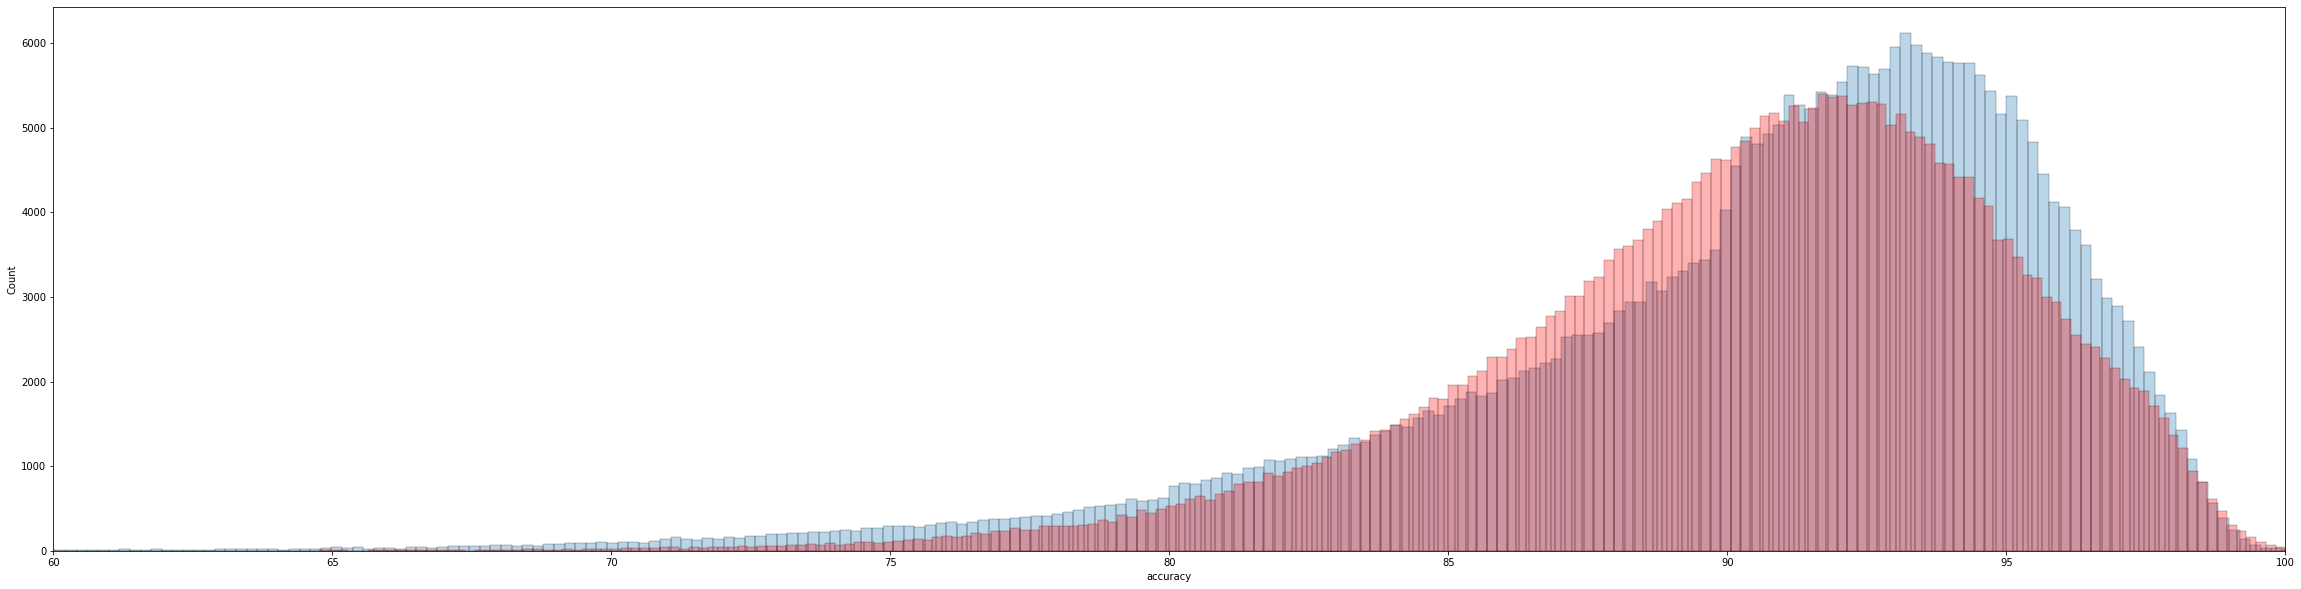

In [20]:
fig, ax = plt.subplots(figsize=(20, 10))
width, height = fig.get_size_inches()
fig.set_size_inches(width*2, height)
sns.histplot(test_data[params['TARGET_NAME']], alpha = 0.3, ax=ax)
sns.histplot(y_pred, alpha = 0.3, color='red', ax=ax)
ax.set_xlim(60, 100)

In [25]:
gbm.booster_.save_model('../models/model_lgbm.txt', num_iteration=gbm.best_iteration_)

In [26]:
gbm = lgbm.Booster(model_file='../models/model_lgbm.txt')

In [28]:
y_pred = gbm.predict(test_data.drop(columns=[params['TARGET_NAME']]))